### To Dos for you:
- Set:
    - output directory path (cell 2)
    - Data file path (cell 3)
    - Converted data out path (optional-uncomment line in cell 5)
    - Encoded data out path (optional- uncomment line in cell 6)
    - Data to use (cell 7)

- Note: When using pEC50, SVR and linear regression perform best. If using EC50, comment out cells 17, 18, 21, 22, 25, and 26




# Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.inspection import permutation_importance
from sklearn.svm import SVR


In [16]:
output_dir = '/Users/lwhitm1/projects/nitazene_opiods/regression_stuff/'
os.makedirs(output_dir, exist_ok=True)

# Data pre-processing

In [2]:
data = pd.read_csv('/Users/lwhitm1/projects/nitazene_opiods/regression_stuff/data_prelim_clean.csv')
print(data.head())
data.info()

                           Compounds     R1    R2         R3  \
0                 1. Metonitazenea,b  –OCH3  –NO2  –N(C2H5)2   
1   2. N-Pyrrolidino metonitazenea,c  –OCH3  –NO2   –N(C4H8)   
2     3. N-Piperidinyl metonitazened  –OCH3  –NO2  –N(C5H10)   
3              4. Metodesnitazenea,b  –OCH3    –H  –N(C2H5)2   
4  5. N-Pyrrolidino metodesnitazened  –OCH3    –H   –N(C4H8)   

  MOR–βarr2 EC50 (nM)   MOR–βarr2 pEC50 MOR–βarr2 Emax (% HM)  \
0    7.19 (4.56–11.2)  8.14 (7.95–8.34)         196 (183–210)   
1    12.0 (8.29–17.4)  7.92 (7.76–8.08)         174 (164–185)   
2      141 (92.4–216)  6.85 (6.66–7.04)         153 (142–163)   
3       433 (258–715)  6.36 (6.15–6.59)         150 (138–162)   
4     1124 (638–1967)  5.95 (5.71–6.20)         124 (110–139)   

  GloSensor® cAMP EC50 (nM) GloSensor® cAMP pEC50 GloSensor® cAMP Emax (% HM)  
0       0.328 (0.201–0.535)      9.49 (9.27–9.70)              100 (94.9–106)  
1       0.475 (0.284–0.770)      9.32 (9.11–9.55)              1

In [3]:
columns_to_convert = ['MOR–βarr2 EC50 (nM)', 'MOR–βarr2 pEC50', 
                      'MOR–βarr2 Emax (% HM)', 'GloSensor® cAMP EC50 (nM)', 
                      'GloSensor® cAMP pEC50', 'GloSensor® cAMP Emax (% HM)']

for col in columns_to_convert:
    data[col] = pd.to_numeric(data[col].str.split().str[0].replace(',', '', regex=True), errors='coerce')


data.info()
print(data.head())

data.to_csv('/Users/lwhitm1/projects/nitazene_opiods/regression_stuff/data_prelim_clean_conv.csv', index=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Compounds                    25 non-null     object 
 1   R1                           25 non-null     object 
 2   R2                           25 non-null     object 
 3   R3                           25 non-null     object 
 4   MOR–βarr2 EC50 (nM)          25 non-null     float64
 5   MOR–βarr2 pEC50              25 non-null     float64
 6   MOR–βarr2 Emax (% HM)        25 non-null     int64  
 7   GloSensor® cAMP EC50 (nM)    25 non-null     float64
 8   GloSensor® cAMP pEC50        25 non-null     float64
 9   GloSensor® cAMP Emax (% HM)  25 non-null     float64
dtypes: float64(5), int64(1), object(4)
memory usage: 2.1+ KB
                           Compounds     R1    R2         R3  \
0                 1. Metonitazenea,b  –OCH3  –NO2  –N(C2H5)2   
1   2. N-Py

In [4]:
categorical_features = ['R1', 'R2', 'R3']

data_encoded = pd.get_dummies(data, columns=categorical_features)

print(data_encoded.head())

data_encoded.to_csv('/Users/lwhitm1/projects/nitazene_opiods/regression_stuff/data_prelim_clean_encoded.csv', index=False)


                           Compounds  MOR–βarr2 EC50 (nM)  MOR–βarr2 pEC50  \
0                 1. Metonitazenea,b                 7.19             8.14   
1   2. N-Pyrrolidino metonitazenea,c                12.00             7.92   
2     3. N-Piperidinyl metonitazened               141.00             6.85   
3              4. Metodesnitazenea,b               433.00             6.36   
4  5. N-Pyrrolidino metodesnitazened              1124.00             5.95   

   MOR–βarr2 Emax (% HM)  GloSensor® cAMP EC50 (nM)  GloSensor® cAMP pEC50  \
0                    196                      0.328                   9.49   
1                    174                      0.475                   9.32   
2                    153                      6.780                   8.17   
3                    150                     33.700                   7.47   
4                    124                     63.900                   7.20   

   GloSensor® cAMP Emax (% HM)  R1_–OC2H5  R1_–OC3H7  R1_–OCH(

# Decide which data to use

In [5]:
# Define the target columns for EC50 values
# target_columns = ['MOR–βarr2 EC50 (nM)', 'GloSensor® cAMP EC50 (nM)']
target_columns = ['MOR–βarr2 pEC50', 'GloSensor® cAMP pEC50']
# Select target data
y_all_numerical = data_encoded[target_columns]  # Keep it as a DataFrame



In [6]:
# Define columns to drop (excluding R group columns)
columns_to_drop = columns_to_convert + ['Compounds']

# Create feature matrix X by dropping the target columns
X = data_encoded.drop(columns=columns_to_drop)

# Proceed with data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y_all_numerical, test_size=0.2, random_state=42)

print(f'X_train shape: {X_train.shape}, X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}, y_test shape: {y_test.shape}')

X_train shape: (20, 11), X_test shape: (5, 11)
y_train shape: (20, 2), y_test shape: (5, 2)


# Simple Linear Regression

In [7]:
# Train
lr_model = MultiOutputRegressor(LinearRegression())
lr_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_lr = lr_model.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr, multioutput='raw_values')
r2_lr = r2_score(y_test, y_pred_lr, multioutput='variance_weighted')

print(f'Linear Regression - Mean Squared Error for Each Target: {mse_lr}')
print(f'Linear Regression - R2 Score: {r2_lr:.2f}')


Linear Regression - Mean Squared Error for Each Target: [0.38137232 0.35700655]
Linear Regression - R2 Score: 0.15


# Random Forest

In [8]:
# Train
rf_model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf, multioutput='raw_values')
r2_rf = r2_score(y_test, y_pred_rf, multioutput='variance_weighted')

print(f'Random Forest - Mean Squared Error for Each Target: {mse_rf}')
print(f'Random Forest - R2 Score: {r2_rf:.2f}')


Random Forest - Mean Squared Error for Each Target: [0.56198256 0.38484582]
Random Forest - R2 Score: -0.09


# Gradient Boosting

In [9]:
# Train
gb_model = MultiOutputRegressor(GradientBoostingRegressor(random_state=42))
gb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_gb = gb_model.predict(X_test)
mse_gb = mean_squared_error(y_test, y_pred_gb, multioutput='raw_values')
r2_gb = r2_score(y_test, y_pred_gb, multioutput='variance_weighted')

print(f'Gradient Boosting - Mean Squared Error for Each Target: {mse_gb}')
print(f'Gradient Boosting - R2 Score: {r2_gb:.2f}')


Gradient Boosting - Mean Squared Error for Each Target: [0.69829072 0.49093256]
Gradient Boosting - R2 Score: -0.37


# SVR

In [10]:
# Scale features
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Train
svr_model = MultiOutputRegressor(SVR(kernel='rbf'))
svr_model.fit(X_train_scaled, y_train_scaled)

# Predict and evaluate
y_pred_svr = svr_model.predict(X_test_scaled)
y_pred_svr = scaler_y.inverse_transform(y_pred_svr)  # Inverse transform to original scale
mse_svr = mean_squared_error(y_test, y_pred_svr, multioutput='raw_values')
r2_svr = r2_score(y_test, y_pred_svr, multioutput='variance_weighted')

print(f'SVR - Mean Squared Error for Each Target: {mse_svr}')
print(f'SVR - R2 Score: {r2_svr:.2f}')


SVR - Mean Squared Error for Each Target: [0.31116569 0.32449304]
SVR - R2 Score: 0.27


# Ridge Regression

In [11]:
# Train
ridge_model = MultiOutputRegressor(Ridge(alpha=1.0))
ridge_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_ridge = ridge_model.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge, multioutput='raw_values')
r2_ridge = r2_score(y_test, y_pred_ridge, multioutput='variance_weighted')

print(f'Ridge Regression - Mean Squared Error for Each Target: {mse_ridge}')
print(f'Ridge Regression - R2 Score: {r2_ridge:.2f}')


Ridge Regression - Mean Squared Error for Each Target: [0.44072736 0.40271604]
Ridge Regression - R2 Score: 0.03


# Lasso

In [12]:
# Train
lasso_model = MultiOutputRegressor(Lasso(alpha=0.1))
lasso_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_lasso = lasso_model.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso, multioutput='raw_values')
r2_lasso = r2_score(y_test, y_pred_lasso, multioutput='variance_weighted')

print(f'Lasso Regression - Mean Squared Error for Each Target: {mse_lasso}')
print(f'Lasso Regression - R2 Score: {r2_lasso:.2f}')


Lasso Regression - Mean Squared Error for Each Target: [0.44624807 0.4120344 ]
Lasso Regression - R2 Score: 0.01


# Elastic Net

In [13]:
# Train
elastic_net_model = MultiOutputRegressor(ElasticNet(alpha=0.1, l1_ratio=0.5))
elastic_net_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_elastic = elastic_net_model.predict(X_test)
mse_elastic = mean_squared_error(y_test, y_pred_elastic, multioutput='raw_values')
r2_elastic = r2_score(y_test, y_pred_elastic, multioutput='variance_weighted')

print(f'Elastic Net Regression - Mean Squared Error for Each Target: {mse_elastic}')
print(f'Elastic Net Regression - R2 Score: {r2_elastic:.2f}')


Elastic Net Regression - Mean Squared Error for Each Target: [0.41553596 0.36408439]
Elastic Net Regression - R2 Score: 0.10


# Model Comp

In [14]:
models = ['Random Forest', 'Gradient Boosting', 'SVR', 'Ridge Regression', 'Lasso Regression', 'Elastic Net Regression', 'Linear Regression']

mse_values = [mse_rf, mse_gb, mse_svr, mse_ridge, mse_lasso, mse_elastic, mse_lr]
r2_scores = [r2_rf, r2_gb, r2_svr, r2_ridge, r2_lasso, r2_elastic, r2_lr] 
comparison_df = pd.DataFrame({
    'Model': models,
    'R2 Score': r2_scores,
    'MSE (Target 1)': [mse[0] for mse in mse_values],
    'MSE (Target 2)': [mse[1] for mse in mse_values]
})
comparison_df.sort_values(by='R2 Score', ascending=False, inplace=True)

print(comparison_df)



                    Model  R2 Score  MSE (Target 1)  MSE (Target 2)
2                     SVR  0.269089        0.311166        0.324493
6       Linear Regression  0.150976        0.381372        0.357007
5  Elastic Net Regression  0.103555        0.415536        0.364084
3        Ridge Regression  0.030168        0.440727        0.402716
4        Lasso Regression  0.013105        0.446248        0.412034
0           Random Forest -0.088709        0.561983        0.384846
1       Gradient Boosting -0.367426        0.698291        0.490933


# Performance Viz

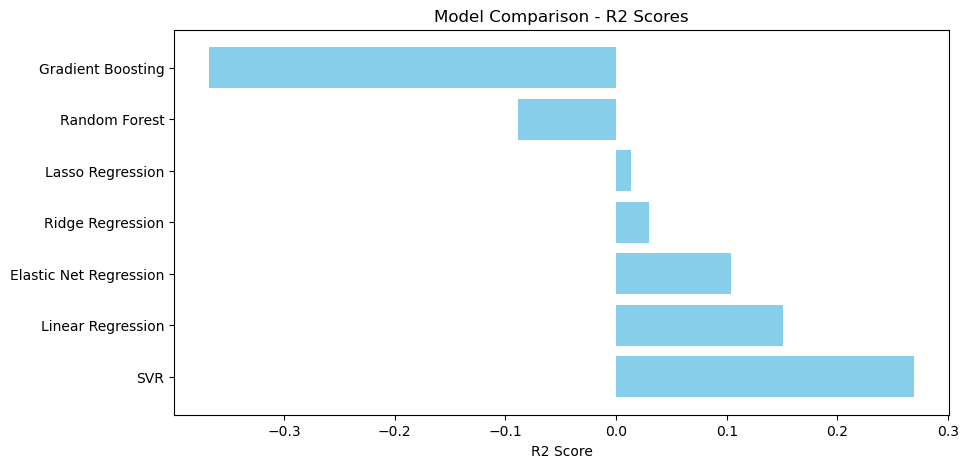

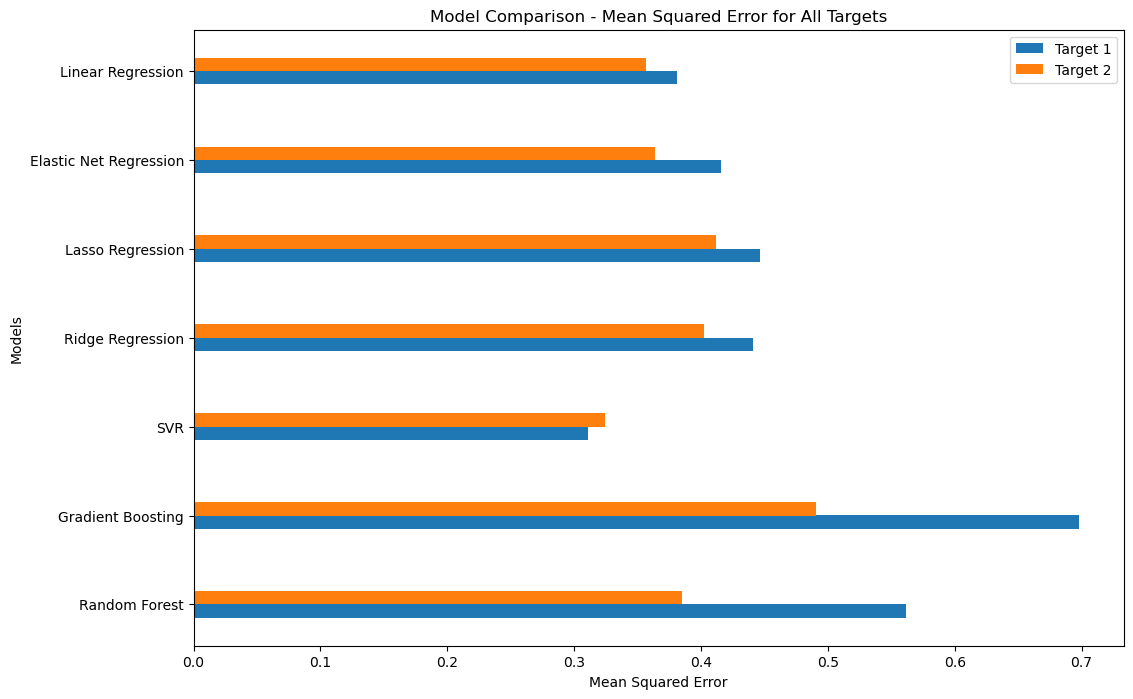

In [17]:
# Visualization of R2 scores
plt.figure(figsize=(10, 5))
plt.barh(comparison_df['Model'], comparison_df['R2 Score'], color='skyblue')
plt.xlabel('R2 Score')
plt.title('Model Comparison - R2 Scores')
filename = f"{output_dir}/model_comp_r2.png"
plt.savefig(filename)
plt.show()

# Visualization of MSE values
num_targets = len(mse_values[0])
y = np.arange(len(models))
height = 0.15

fig, ax = plt.subplots(figsize=(12, 8))

for i in range(num_targets):
    mse_for_target = [mse[i] for mse in mse_values]
    ax.barh(y + i * height, mse_for_target, height, label=f'Target {i+1}')
ax.set_ylabel('Models')
ax.set_xlabel('Mean Squared Error')
ax.set_title('Model Comparison - Mean Squared Error for All Targets')
ax.set_yticks(y + height * (num_targets - 1) / 2)
ax.set_yticklabels(models)
ax.legend()
filename = f"{output_dir}/model_comp_mse.png"
plt.savefig(filename)
plt.show()

# Coefficients

In [ ]:
# Function to get coefficients from the MultiOutputRegressor model
def get_coefficients(model, model_name, X_columns):
    coefficients = []
    for i, estimator in enumerate(model.estimators_):
        coef_dict = {"Model": model_name, "Target": f"Target {i+1}"}
        coef_dict.update({feature: coef for feature, coef in zip(X_columns, estimator.coef_)})
        coefficients.append(coef_dict)
    return coefficients

# Extract coefficients for each model
lr_coefficients = get_coefficients(lr_model, "Linear Regression", X_train.columns)
lasso_coefficients = get_coefficients(lasso_model, "Lasso Regression", X_train.columns)
ridge_coefficients = get_coefficients(ridge_model, "Ridge Regression", X_train.columns)
elastic_net_model = get_coefficients(elastic_net_model, "Elastic Net Regression", X_train.columns)

# Combine all coefficients into a single DataFrame
all_coefficients = pd.DataFrame(lr_coefficients + lasso_coefficients + ridge_coefficients + elastic_net_model)

# Display the table
print(all_coefficients)

# export to csv
all_coefficients.to_csv(f"{output_dir}/double_target_model_coefficients.csv", index=False)



                    Model    Target  R1_–OC2H5  R1_–OC3H7  R1_–OCH(CH3)2  \
0       Linear Regression  Target 1   0.643616   0.543342       0.950671   
1       Linear Regression  Target 2   0.771425   0.366014       0.839507   
2        Lasso Regression  Target 1   0.000000   0.000000       0.252653   
3        Lasso Regression  Target 2   0.000000   0.000000       0.199829   
4        Ridge Regression  Target 1   0.452013   0.413093       0.765829   
5        Ridge Regression  Target 2   0.552383   0.268247       0.678893   
6  Elastic Net Regression  Target 1   0.065682   0.021948       0.418380   
7  Elastic Net Regression  Target 2   0.219429   0.000000       0.401360   

   R1_–OCH3    R1_–OH     R2_–H       R2_–NO2  R3_–N(C2H5)2  R3_–N(C4H8)  \
0 -0.900699 -1.236932 -0.758913  7.589127e-01      0.046331     0.251006   
1 -0.782548 -1.194397 -0.701807  7.018065e-01     -0.017222     0.226665   
2 -0.898079 -0.503633 -0.816384  1.057355e-16     -0.000000     0.000000   
3 -0.714246

# Moving forward with Random Forest and Gradient Boosting

## Feature Importance

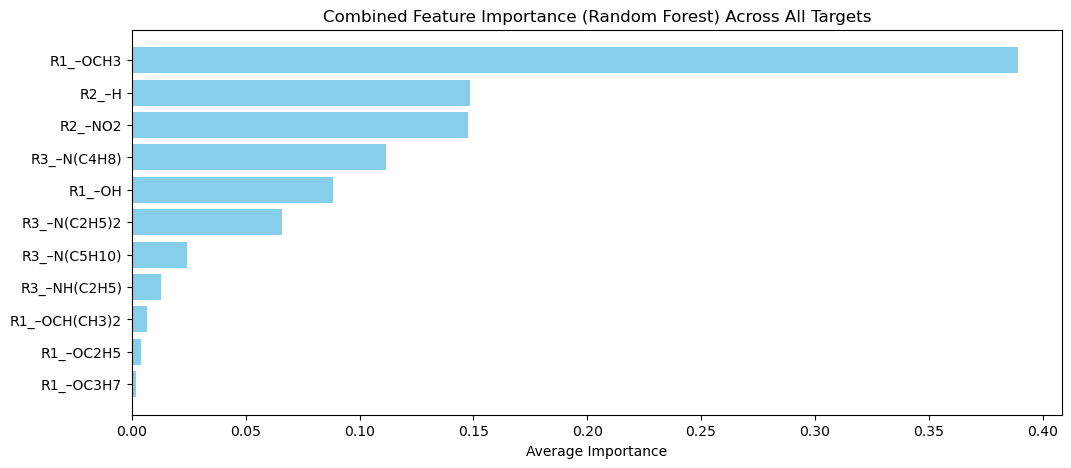

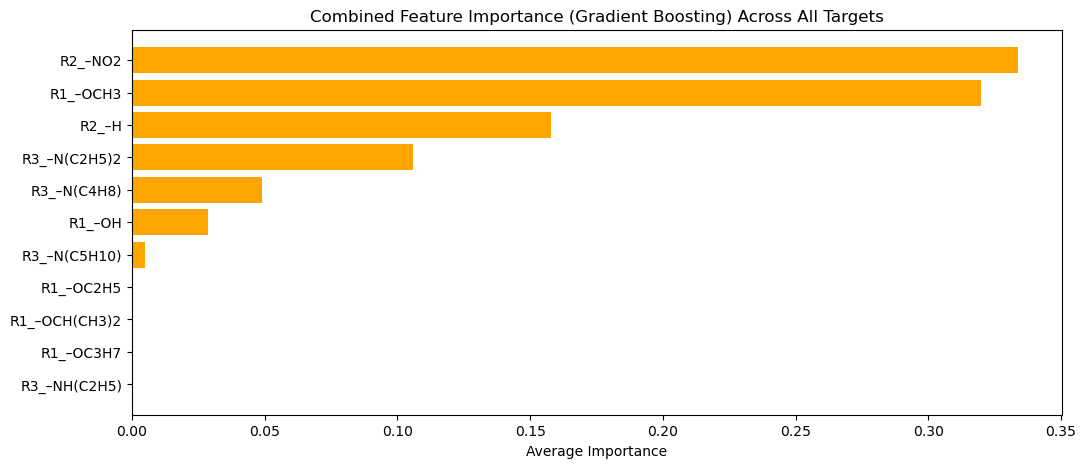

In [17]:
# Calculate general feature importance for Random Forest
rf_combined_importance = np.mean([rf_model.estimators_[i].feature_importances_ for i in range(len(target_columns))], axis=0)
rf_combined_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_combined_importance
}).sort_values(by='Importance', ascending=False)

# Calculate general feature importance for Gradient Boosting
gb_combined_importance = np.mean([gb_model.estimators_[i].feature_importances_ for i in range(len(target_columns))], axis=0)
gb_combined_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': gb_combined_importance
}).sort_values(by='Importance', ascending=False)

# Plot combined feature importance for Random Forest
plt.figure(figsize=(12, 5))
plt.barh(rf_combined_importance_df['Feature'], rf_combined_importance_df['Importance'], color='skyblue')
plt.xlabel('Average Importance')
plt.title('Combined Feature Importance (Random Forest) Across All Targets')
plt.gca().invert_yaxis()
filename = f"{output_dir}/feature_importance_combined_rf.png"
plt.savefig(filename)
plt.show()

# Plot combined feature importance for Gradient Boosting
plt.figure(figsize=(12, 5))
plt.barh(gb_combined_importance_df['Feature'], gb_combined_importance_df['Importance'], color='orange')
plt.xlabel('Average Importance')
plt.title('Combined Feature Importance (Gradient Boosting) Across All Targets')
plt.gca().invert_yaxis()
filename = f"{output_dir}/feature_importance_combined_gb.png"
plt.savefig(filename)
plt.show()


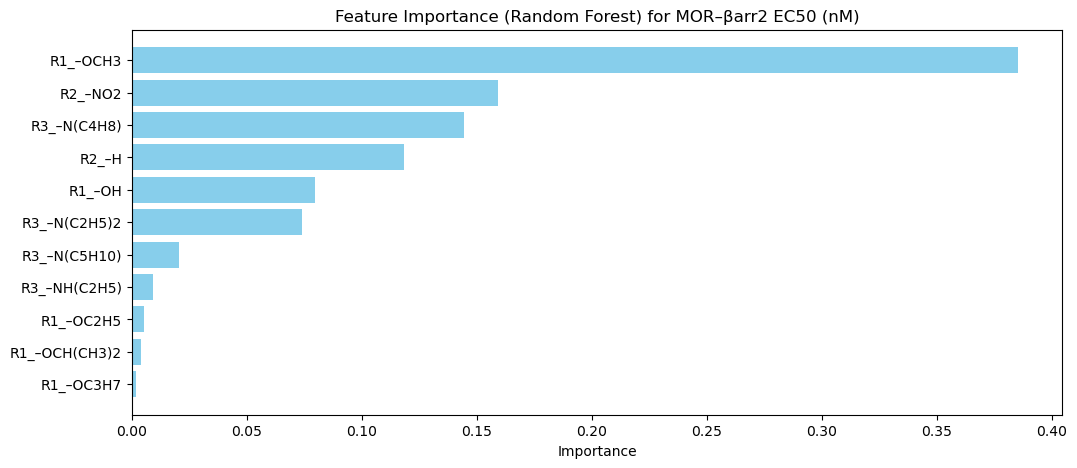

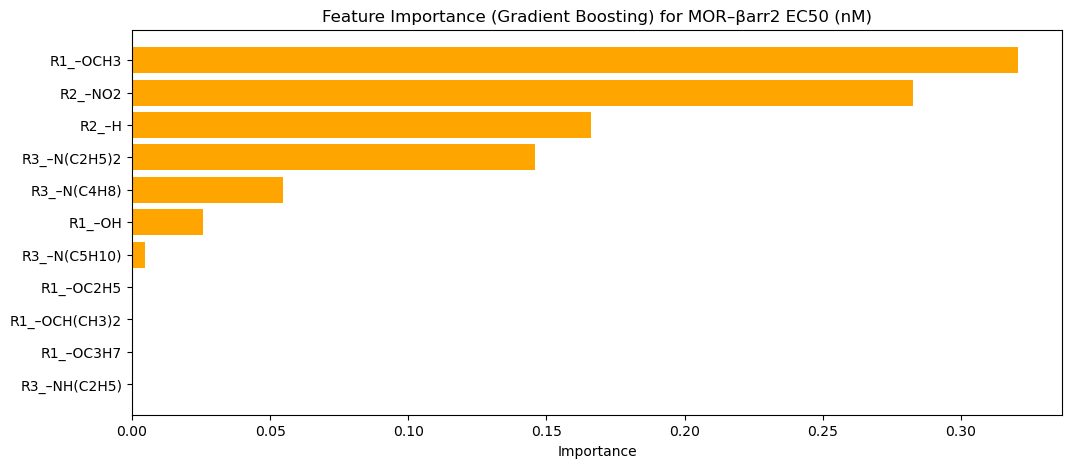

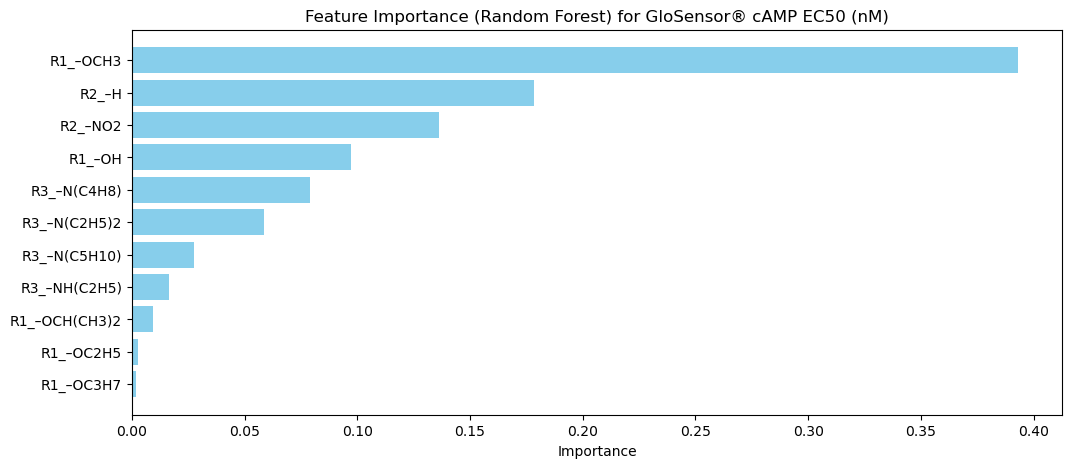

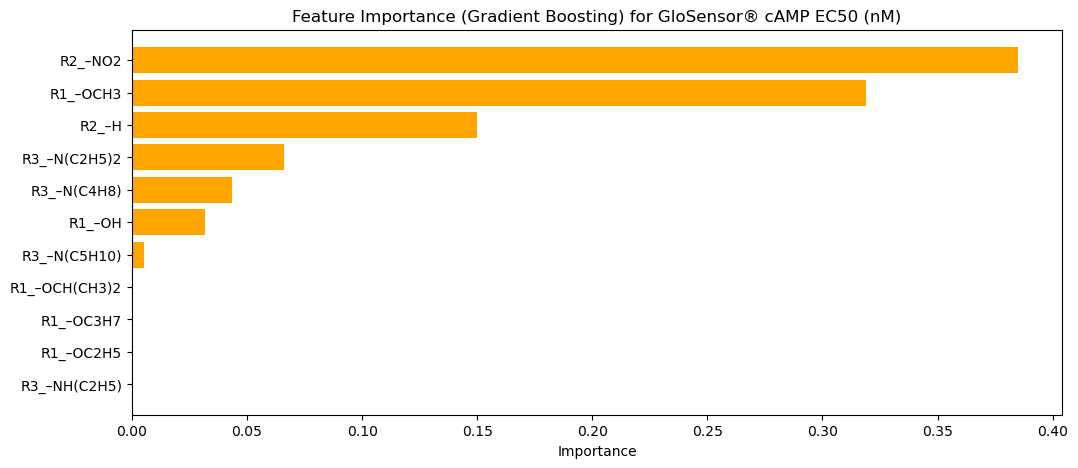

In [18]:
# Loop through each target for Random Forest and Gradient Boosting
for i, target in enumerate(target_columns):
    # Random Forest feature importance
    rf_feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf_model.estimators_[i].feature_importances_
    }).sort_values(by='Importance', ascending=False)

    # Gradient Boosting feature importance
    gb_feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': gb_model.estimators_[i].feature_importances_
    }).sort_values(by='Importance', ascending=False)

    # Plotting Random Forest Feature Importance
    plt.figure(figsize=(12, 5))
    plt.barh(rf_feature_importance['Feature'], rf_feature_importance['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.title(f'Feature Importance (Random Forest) for {target}')
    plt.gca().invert_yaxis()
    filename = f"{output_dir}/feature_importance_rf_{target.replace(' ', '_').replace('/', '_').replace('–', '-')}.png"
    plt.savefig(filename)
    plt.show()

    # Plotting Gradient Boosting Feature Importance
    plt.figure(figsize=(12, 5))
    plt.barh(gb_feature_importance['Feature'], gb_feature_importance['Importance'], color='orange')
    plt.xlabel('Importance')
    plt.title(f'Feature Importance (Gradient Boosting) for {target}')
    plt.gca().invert_yaxis()
    filename = f"{output_dir}/feature_importance_gb_{target.replace(' ', '_').replace('/', '_').replace('–', '-')}.png"
    plt.savefig(filename)
    plt.show()


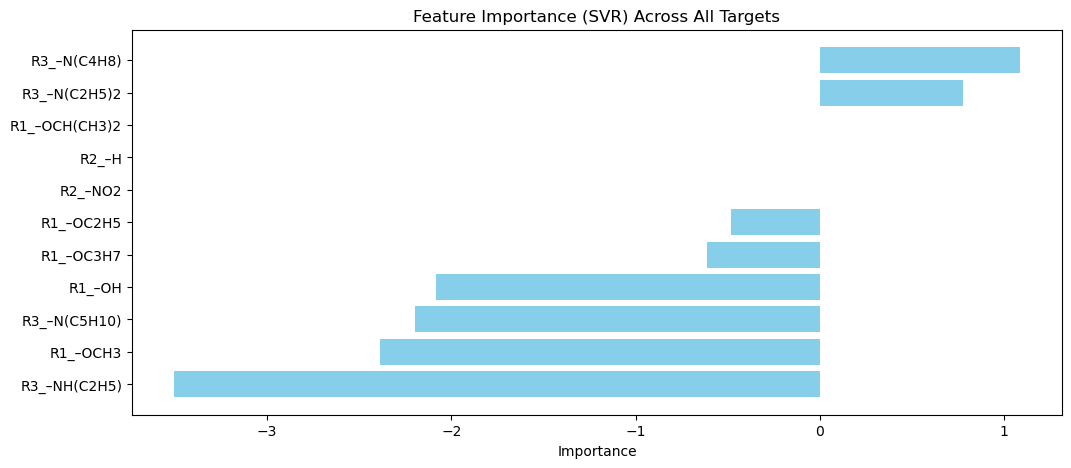

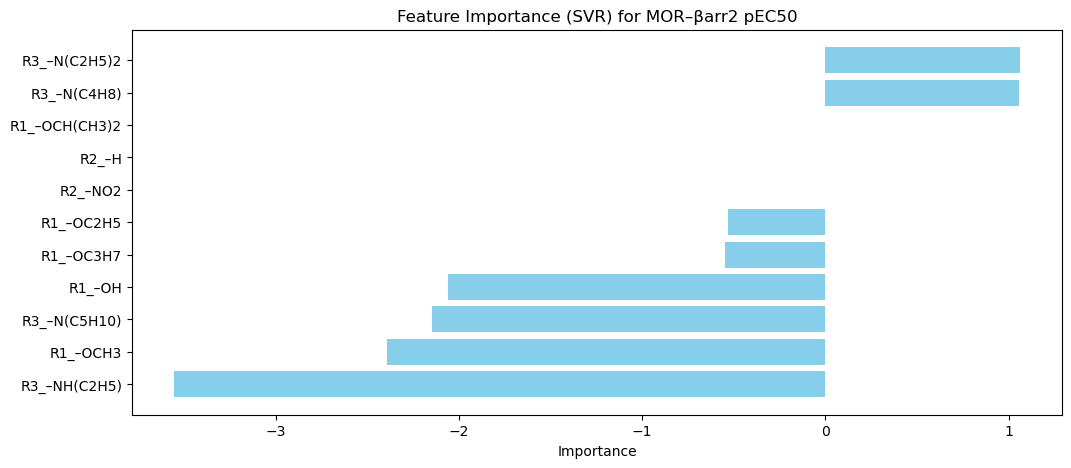

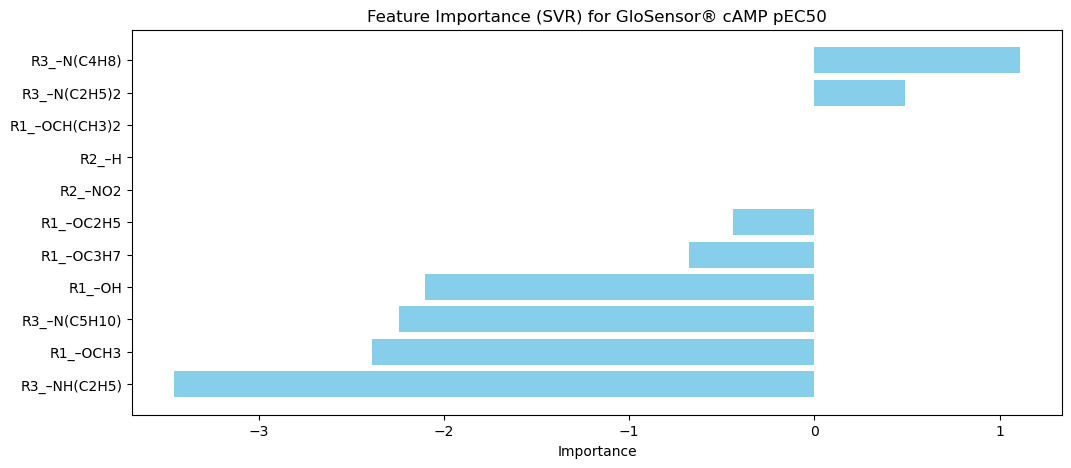

In [17]:
# SVR
# Calculate general feature importance for SVR
svr_importance = permutation_importance(svr_model, X_test_scaled, y_test, n_repeats=10, random_state=42)
svr_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': svr_importance['importances_mean']
}).sort_values(by='Importance', ascending=False)

# Plot combined feature importance for SVR
plt.figure(figsize=(12, 5))
plt.barh(svr_importance_df['Feature'], svr_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance (SVR) Across All Targets')
plt.gca().invert_yaxis()
filename = f"{output_dir}/feature_importance_svr.png"
plt.savefig(filename)
plt.show()

# Loop through each target for SVR
for i, target in enumerate(target_columns):
    # SVR feature importance
    svr_importance = permutation_importance(svr_model.estimators_[i], X_test_scaled, y_test.iloc[:, i], n_repeats=10, random_state=42)
    svr_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': svr_importance['importances_mean']
    }).sort_values(by='Importance', ascending=False)

    # Plotting SVR Feature Importance
    plt.figure(figsize=(12, 5))
    plt.barh(svr_importance_df['Feature'], svr_importance_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.title(f'Feature Importance (SVR) for {target}')
    plt.gca().invert_yaxis()
    filename = f"{output_dir}/feature_importance_svr_{target.replace(' ', '_').replace('/', '_').replace('–', '-')}.png"
    plt.savefig(filename)
    plt.show()

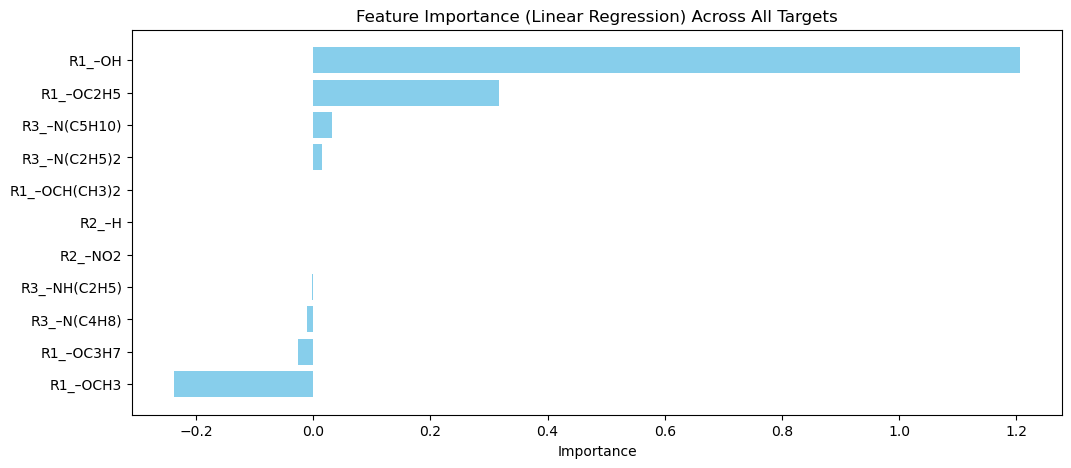

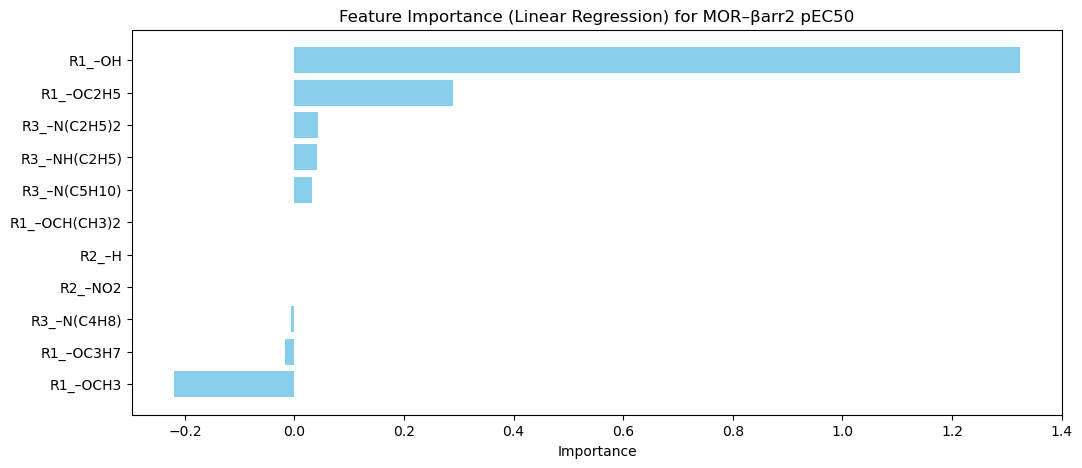

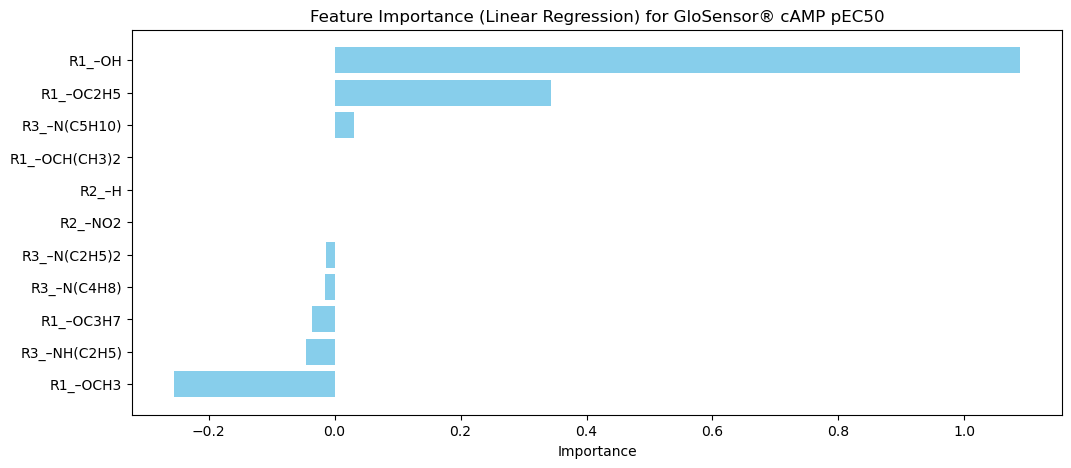

In [18]:
# Linear Regression
# Calculate general feature importance for Linear Regression
lr_importance = permutation_importance(lr_model, X_test, y_test, n_repeats=10, random_state=42)
lr_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': lr_importance['importances_mean']
}).sort_values(by='Importance', ascending=False)

# Plot combined feature importance for Linear Regression
plt.figure(figsize=(12, 5))
plt.barh(lr_importance_df['Feature'], lr_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance (Linear Regression) Across All Targets')
plt.gca().invert_yaxis()
filename = f"{output_dir}/feature_importance_lr.png"
plt.savefig(filename)
plt.show()

# Loop through each target for Linear Regression
for i, target in enumerate(target_columns):
    # Linear Regression feature importance
    lr_importance = permutation_importance(lr_model.estimators_[i], X_test, y_test.iloc[:, i], n_repeats=10, random_state=42)
    lr_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': lr_importance['importances_mean']
    }).sort_values(by='Importance', ascending=False)

    # Plotting Linear Regression Feature Importance
    plt.figure(figsize=(12, 5))
    plt.barh(lr_importance_df['Feature'], lr_importance_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.title(f'Feature Importance (Linear Regression) for {target}')
    plt.gca().invert_yaxis()
    filename = f"{output_dir}/feature_importance_lr_{target.replace(' ', '_').replace('/', '_').replace('–', '-')}.png"
    plt.savefig(filename)
    plt.show()


## Permutation

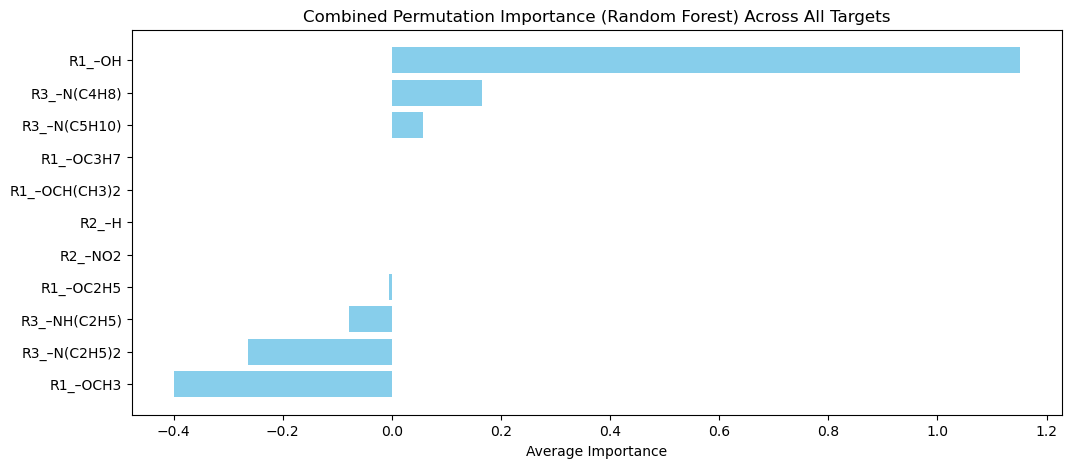

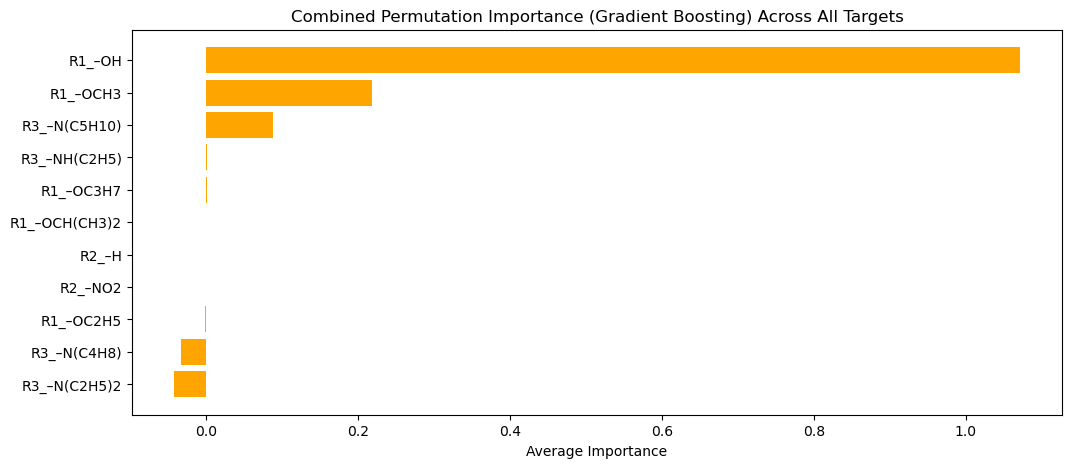

In [19]:
# Calculate combined feature importance across all targets for Random Forest
rf_combined_importance = np.zeros(X.shape[1])

for i in range(len(target_columns)):
    result_rf = permutation_importance(rf_model.estimators_[i], X_test, y_test.iloc[:, i], n_repeats=50, random_state=42)
    rf_combined_importance += result_rf.importances_mean  # Summing importance for combined analysis

rf_combined_importance /= len(target_columns)  # Averaging across targets

# Plot combined feature importance for Random Forest
rf_combined_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_combined_importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 5))
plt.barh(rf_combined_importance_df['Feature'], rf_combined_importance_df['Importance'], color='skyblue')
plt.xlabel('Average Importance')
plt.title('Combined Permutation Importance (Random Forest) Across All Targets')
plt.gca().invert_yaxis()
filename = f"{output_dir}/permutation_combined_rf.png"
plt.savefig(filename)
plt.show()

# Calculate combined feature importance across all targets for Gradient Boosting
gb_combined_importance = np.zeros(X.shape[1])

for i in range(len(target_columns)):
    result_gb = permutation_importance(gb_model.estimators_[i], X_test, y_test.iloc[:, i], n_repeats=50, random_state=42)
    gb_combined_importance += result_gb.importances_mean  # Summing importance for combined analysis

gb_combined_importance /= len(target_columns)  # Averaging across targets

# Plot combined feature importance for Gradient Boosting
gb_combined_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': gb_combined_importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 5))
plt.barh(gb_combined_importance_df['Feature'], gb_combined_importance_df['Importance'], color='orange')
plt.xlabel('Average Importance')
plt.title('Combined Permutation Importance (Gradient Boosting) Across All Targets')
plt.gca().invert_yaxis()
filename = f"{output_dir}/permutation_combined_gb.png"
plt.savefig(filename)
plt.show()


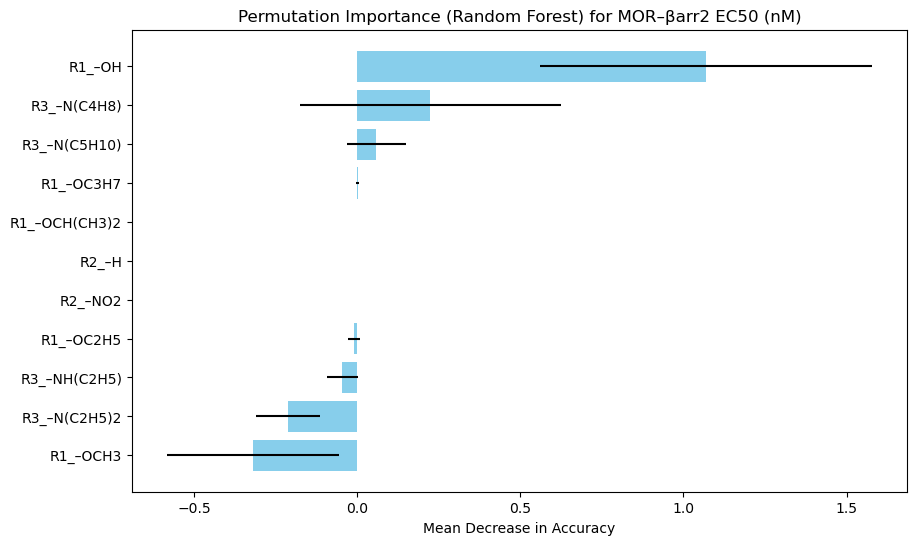

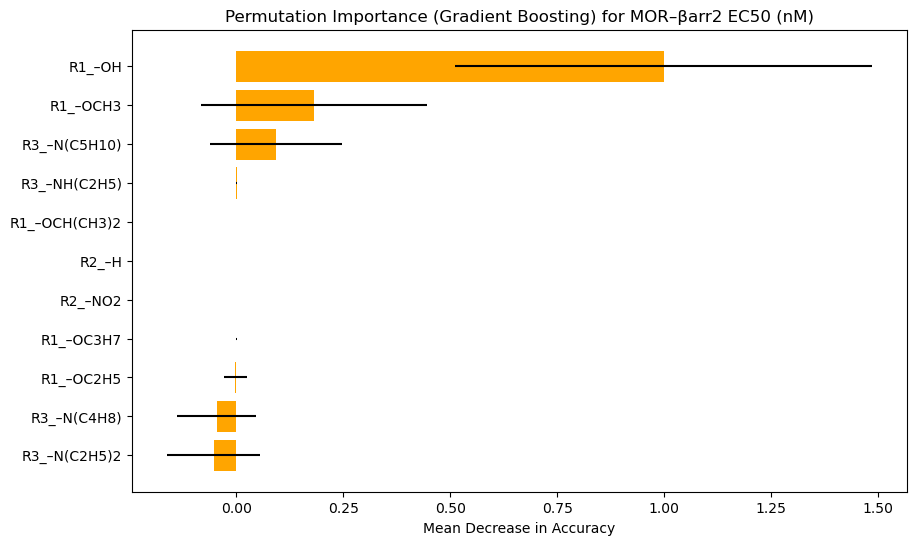

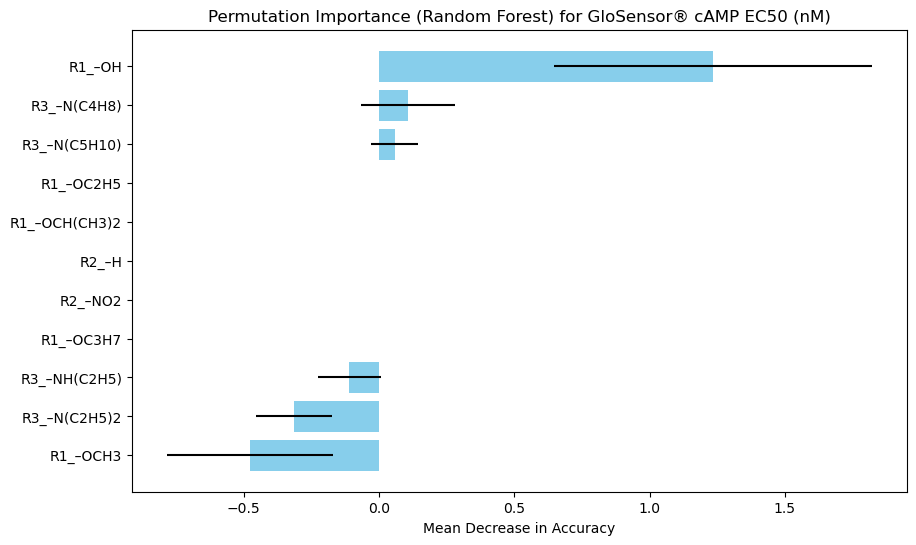

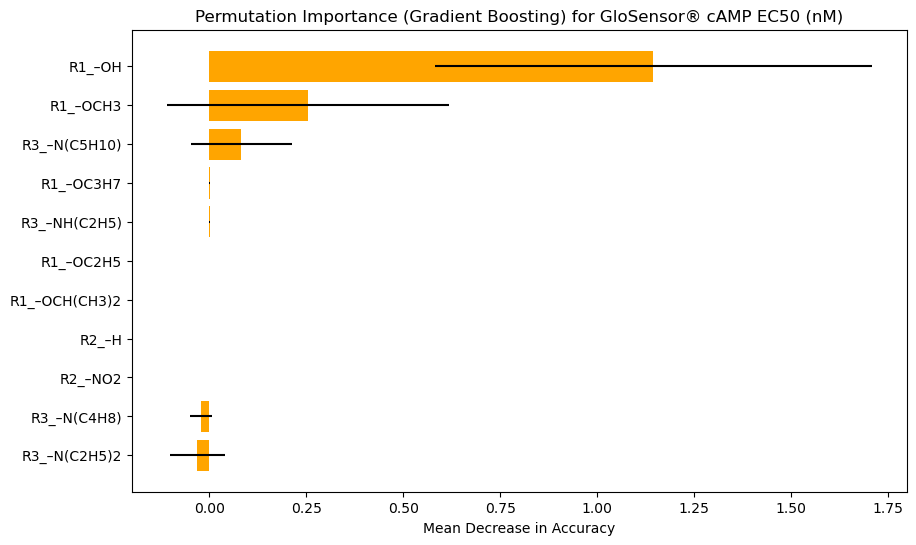

In [20]:
# Loop through each target for permutation importance using Random Forest and Gradient Boosting
for i, target in enumerate(target_columns):
    # Random Forest permutation importance
    result_rf = permutation_importance(rf_model.estimators_[i], X_test, y_test.iloc[:, i], n_repeats=50, random_state=42)
    perm_importance_rf = pd.DataFrame({
        'Feature': X.columns,
        'Importance': result_rf.importances_mean,
        'Std Dev': result_rf.importances_std
    }).sort_values(by='Importance', ascending=False)

    # Plot for Random Forest
    plt.figure(figsize=(10, 6))
    plt.barh(perm_importance_rf['Feature'], perm_importance_rf['Importance'], xerr=perm_importance_rf['Std Dev'], color='skyblue')
    plt.xlabel('Mean Decrease in Accuracy')
    plt.title(f'Permutation Importance (Random Forest) for {target}')
    plt.gca().invert_yaxis()
    filename = f"{output_dir}/permutation_rf_{target.replace(' ', '_').replace('/', '_').replace('–', '-')}.png"
    plt.savefig(filename)
    plt.show()

    # Gradient Boosting permutation importance
    result_gb = permutation_importance(gb_model.estimators_[i], X_test, y_test.iloc[:, i], n_repeats=50, random_state=42)
    perm_importance_gb = pd.DataFrame({
        'Feature': X.columns,
        'Importance': result_gb.importances_mean,
        'Std Dev': result_gb.importances_std
    }).sort_values(by='Importance', ascending=False)

    # Plot for Gradient Boosting
    plt.figure(figsize=(10, 6))
    plt.barh(perm_importance_gb['Feature'], perm_importance_gb['Importance'], xerr=perm_importance_gb['Std Dev'], color='orange')
    plt.xlabel('Mean Decrease in Accuracy')
    plt.title(f'Permutation Importance (Gradient Boosting) for {target}')
    plt.gca().invert_yaxis()
    filename = f"{output_dir}/permutation_gb_{target.replace(' ', '_').replace('/', '_').replace('–', '-')}.png"
    plt.savefig(filename)
    plt.show()


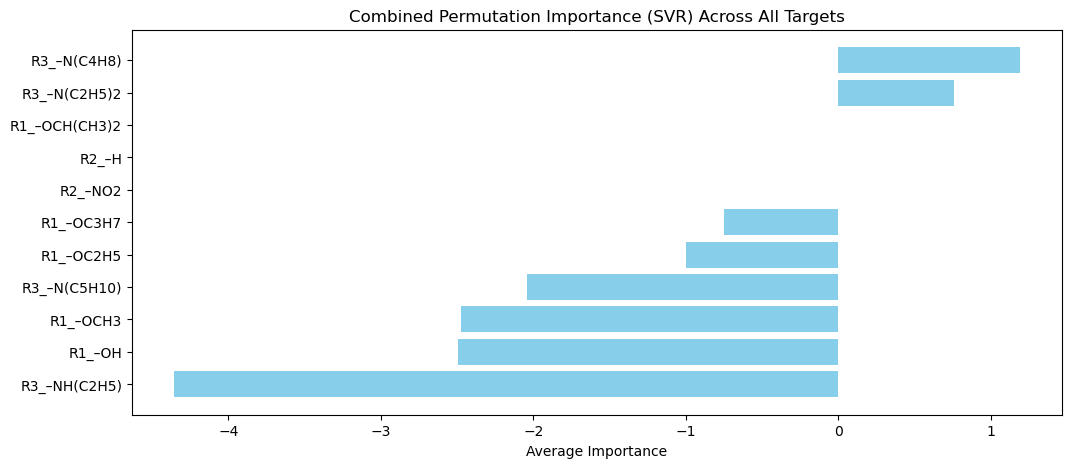

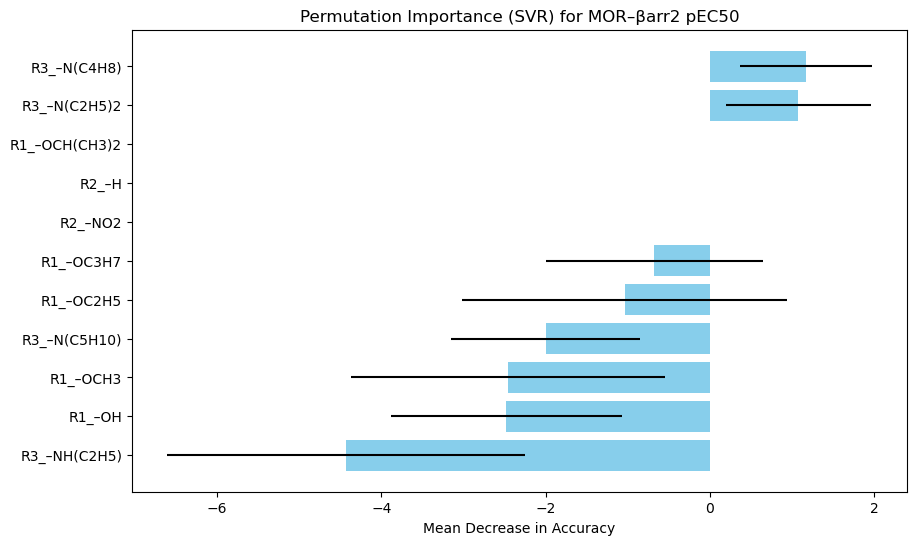

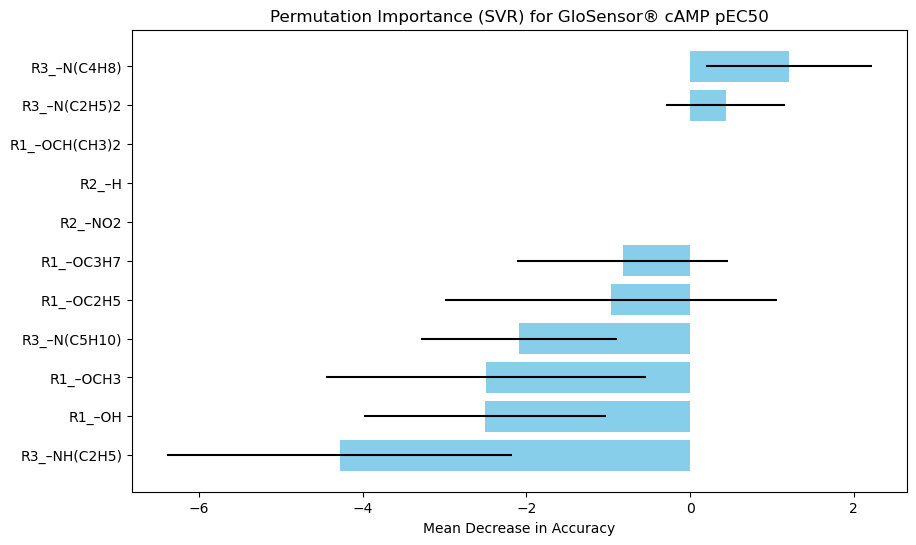

In [19]:
# Permutation importance for SVR
# Calculate combined feature importance across all targets for SVR
svr_combined_importance = np.zeros(X.shape[1])

for i in range(len(target_columns)):
    result_svr = permutation_importance(svr_model.estimators_[i], X_test_scaled, y_test.iloc[:, i], n_repeats=50, random_state=42)
    svr_combined_importance += result_svr.importances_mean  # Summing importance for combined analysis

svr_combined_importance /= len(target_columns)  # Averaging across targets

# Plot combined feature importance for SVR
svr_combined_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': svr_combined_importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 5))
plt.barh(svr_combined_importance_df['Feature'], svr_combined_importance_df['Importance'], color='skyblue')
plt.xlabel('Average Importance')
plt.title('Combined Permutation Importance (SVR) Across All Targets')
plt.gca().invert_yaxis()
filename = f"{output_dir}/permutation_combined_svr.png"
plt.savefig(filename)
plt.show()

# Loop through each target for permutation importance using SVR
for i, target in enumerate(target_columns):
    # SVR permutation importance
    result_svr = permutation_importance(svr_model.estimators_[i], X_test_scaled, y_test.iloc[:, i], n_repeats=50, random_state=42)
    perm_importance_svr = pd.DataFrame({
        'Feature': X.columns,
        'Importance': result_svr.importances_mean,
        'Std Dev': result_svr.importances_std
    }).sort_values(by='Importance', ascending=False)

    # Plot for SVR
    plt.figure(figsize=(10, 6))
    plt.barh(perm_importance_svr['Feature'], perm_importance_svr['Importance'], xerr=perm_importance_svr['Std Dev'], color='skyblue')
    plt.xlabel('Mean Decrease in Accuracy')
    plt.title(f'Permutation Importance (SVR) for {target}')
    plt.gca().invert_yaxis()
    filename = f"{output_dir}/permutation_svr_{target.replace(' ', '_').replace('/', '_').replace('–', '-')}.png"
    plt.savefig(filename)
    plt.show()

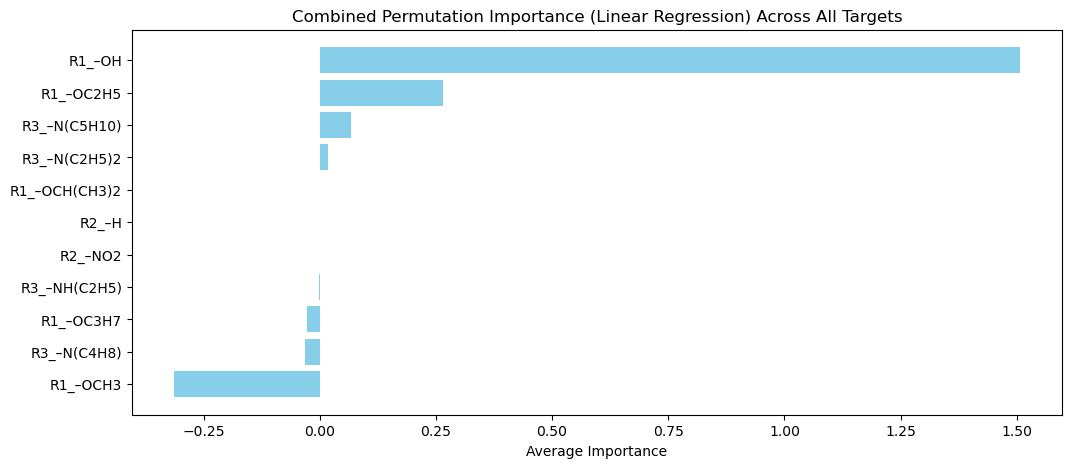

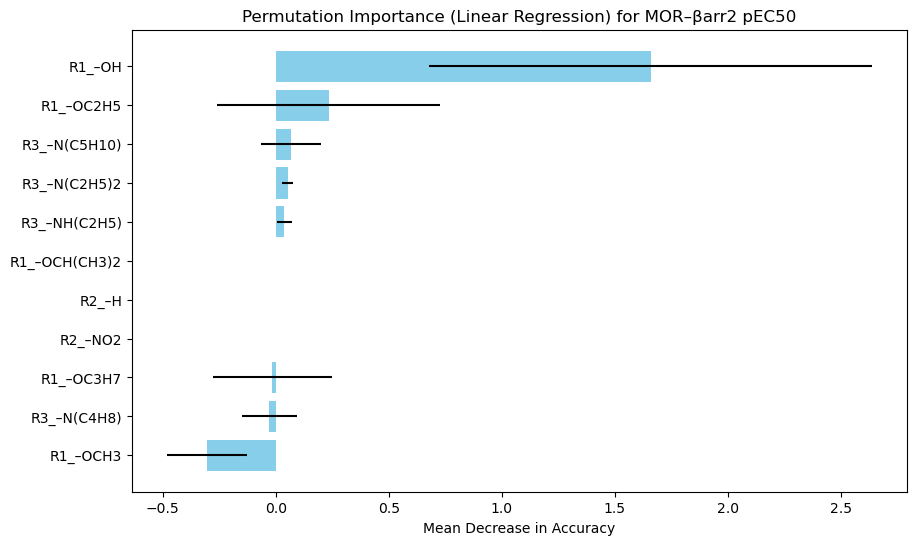

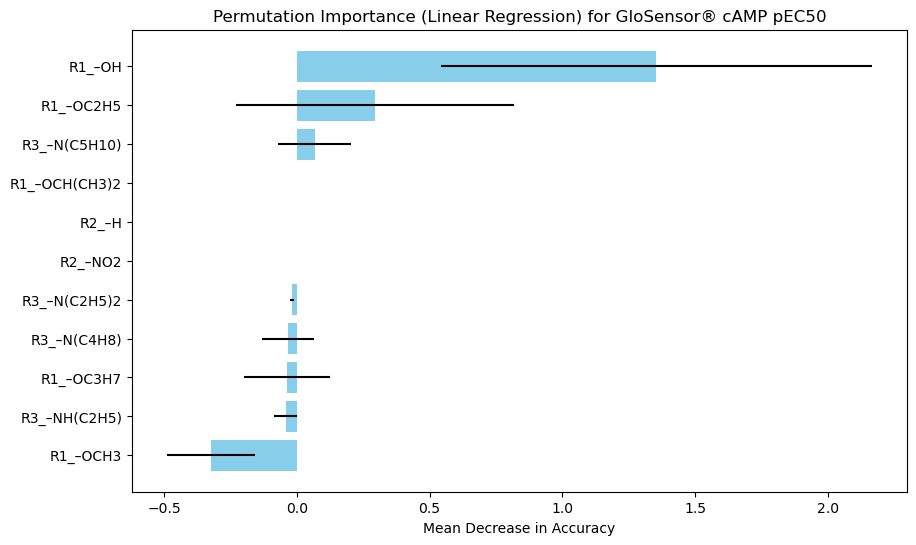

In [20]:
# Permutation importance for Linear Regression
# Calculate combined feature importance across all targets for Linear Regression
lr_combined_importance = np.zeros(X.shape[1])

for i in range(len(target_columns)):
    result_lr = permutation_importance(lr_model.estimators_[i], X_test, y_test.iloc[:, i], n_repeats=50, random_state=42)
    lr_combined_importance += result_lr.importances_mean  # Summing importance for combined analysis

lr_combined_importance /= len(target_columns)  # Averaging across targets

# Plot combined feature importance for Linear Regression
lr_combined_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': lr_combined_importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 5))
plt.barh(lr_combined_importance_df['Feature'], lr_combined_importance_df['Importance'], color='skyblue')
plt.xlabel('Average Importance')
plt.title('Combined Permutation Importance (Linear Regression) Across All Targets')
plt.gca().invert_yaxis()
filename = f"{output_dir}/permutation_combined_lr.png"
plt.savefig(filename)
plt.show()

# Loop through each target for permutation importance using Linear Regression
for i, target in enumerate(target_columns):
    # Linear Regression permutation importance
    result_lr = permutation_importance(lr_model.estimators_[i], X_test, y_test.iloc[:, i], n_repeats=50, random_state=42)
    perm_importance_lr = pd.DataFrame({
        'Feature': X.columns,
        'Importance': result_lr.importances_mean,
        'Std Dev': result_lr.importances_std
    }).sort_values(by='Importance', ascending=False)

    # Plot for Linear Regression
    plt.figure(figsize=(10, 6))
    plt.barh(perm_importance_lr['Feature'], perm_importance_lr['Importance'], xerr=perm_importance_lr['Std Dev'], color='skyblue')
    plt.xlabel('Mean Decrease in Accuracy')
    plt.title(f'Permutation Importance (Linear Regression) for {target}')
    plt.gca().invert_yaxis()
    filename = f"{output_dir}/permutation_lr_{target.replace(' ', '_').replace('/', '_').replace('–', '-')}.png"
    plt.savefig(filename)
    plt.show()
    

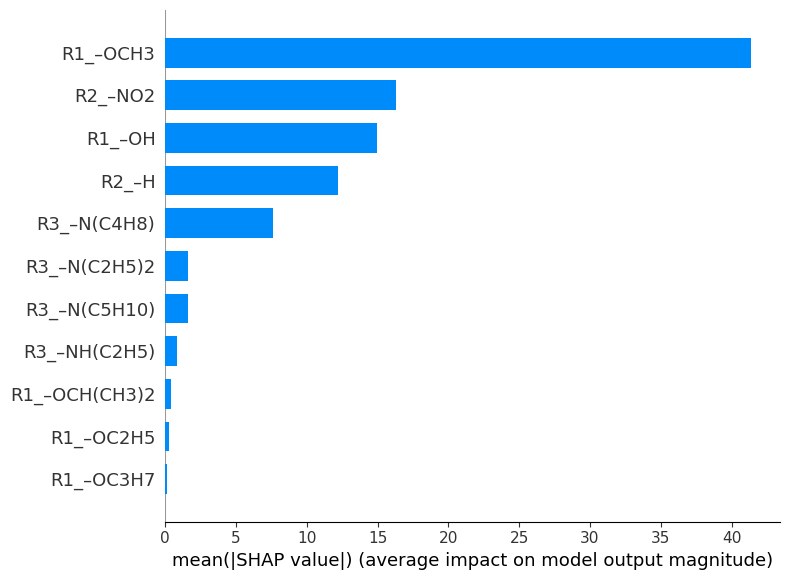

In [21]:
# Calculate combined SHAP values across all targets for Random Forest
shap_values_rf_combined = []

for i in range(len(target_columns)):
    explainer_rf = shap.TreeExplainer(rf_model.estimators_[i])
    shap_values_rf = explainer_rf.shap_values(X_test)
    shap_values_rf_combined.append(shap_values_rf)

# Averaging SHAP values across targets for Random Forest
shap_values_rf_combined = np.mean(np.array(shap_values_rf_combined), axis=0)

# Visualize combined SHAP values for Random Forest
shap.summary_plot(shap_values_rf_combined, X_test, feature_names=X.columns, plot_type="bar")


# Scikt-learn GB does not support SHAP for the combined targets



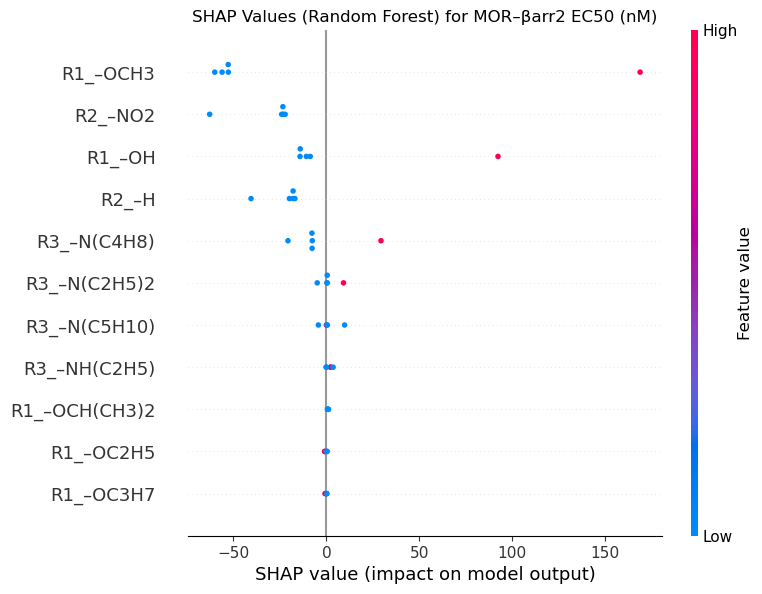

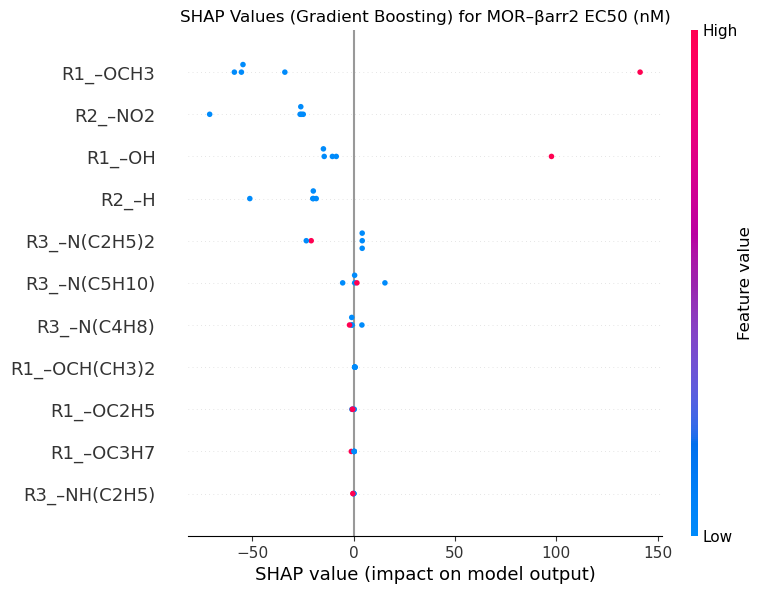

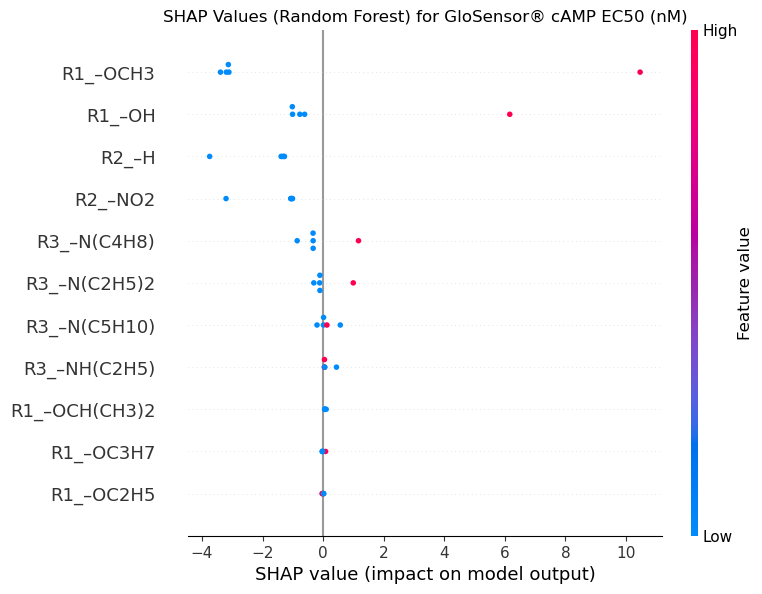

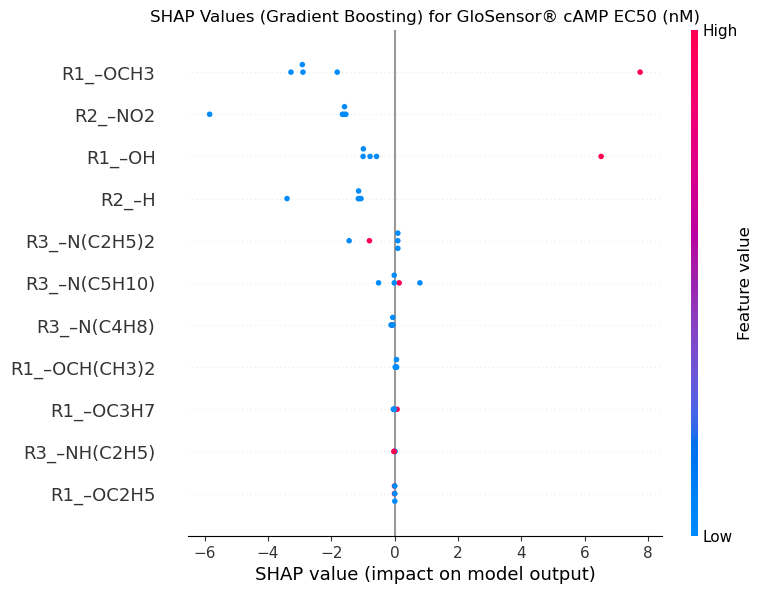

In [22]:
# SHAP analysis for all targets using Random Forest and Gradient Boosting
for i, target in enumerate(target_columns):
    # Random Forest SHAP values
    explainer_rf = shap.TreeExplainer(rf_model.estimators_[i])
    shap_values_rf = explainer_rf.shap_values(X_test)

    # Visualize SHAP summary for Random Forest
    shap.summary_plot(shap_values_rf, X_test, feature_names=X.columns, show=False)
    plt.title(f'SHAP Values (Random Forest) for {target}')
    filename = f"{output_dir}/shap_rf_{target.replace(' ', '_').replace('/', '_').replace('–', '-')}.png"
    plt.savefig(filename)
    plt.show()

    # Gradient Boosting SHAP values
    explainer_gb = shap.TreeExplainer(gb_model.estimators_[i])
    shap_values_gb = explainer_gb.shap_values(X_test)

    # Visualize SHAP summary for Gradient Boosting
    shap.summary_plot(shap_values_gb, X_test, feature_names=X.columns, show=False)
    plt.title(f'SHAP Values (Gradient Boosting) for {target}')
    filename = f"{output_dir}/shap_gb_{target.replace(' ', '_').replace('/', '_').replace('–', '-')}.png"
    plt.savefig(filename)
    plt.show()


  0%|          | 0/5 [00:00<?, ?it/s]

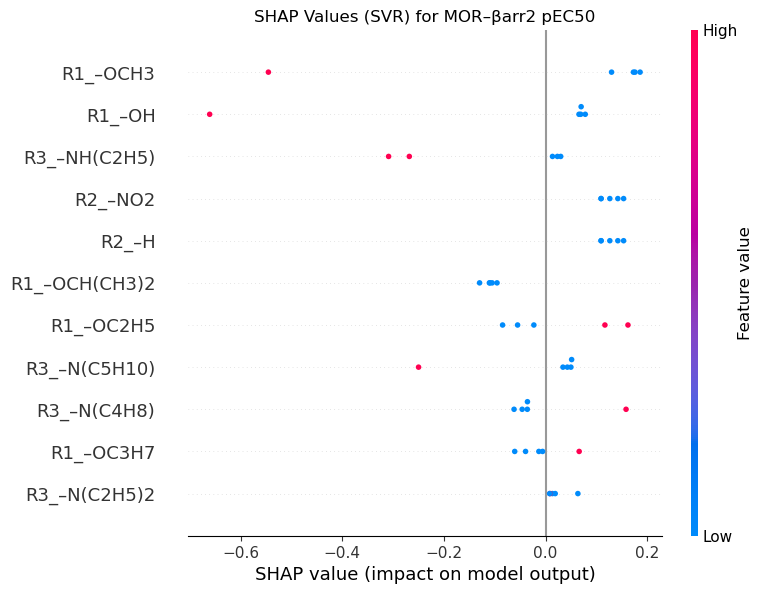

  0%|          | 0/5 [00:00<?, ?it/s]

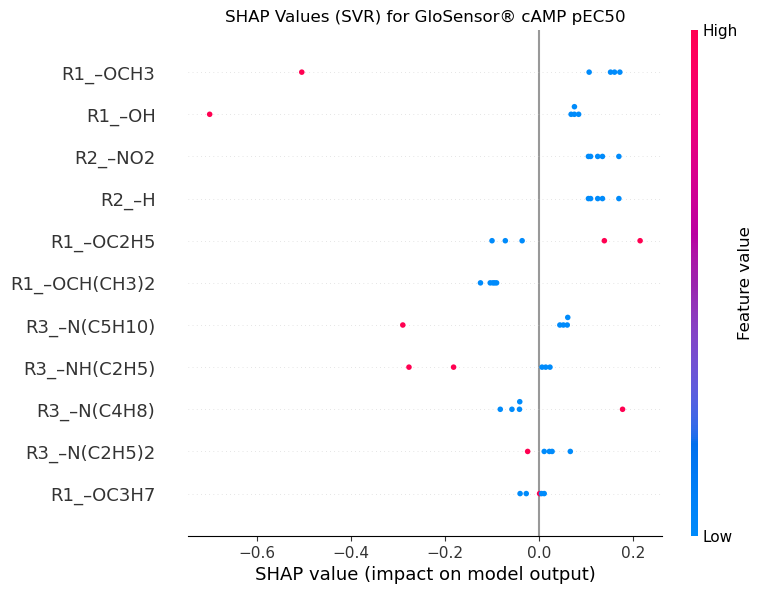

In [21]:
# SHAP analysis for all targets using SVR
for i, target in enumerate(target_columns):
    # SVR SHAP values
    explainer_svr = shap.KernelExplainer(svr_model.estimators_[i].predict, X_train_scaled)
    shap_values_svr = explainer_svr.shap_values(X_test_scaled)

    # Visualize SHAP summary for SVR
    shap.summary_plot(shap_values_svr, X_test, feature_names=X.columns, show=False)
    plt.title(f'SHAP Values (SVR) for {target}')
    filename = f"{output_dir}/shap_svr_{target.replace(' ', '_').replace('/', '_').replace('–', '-')}.png"
    plt.savefig(filename)
    plt.show()

  0%|          | 0/5 [00:00<?, ?it/s]

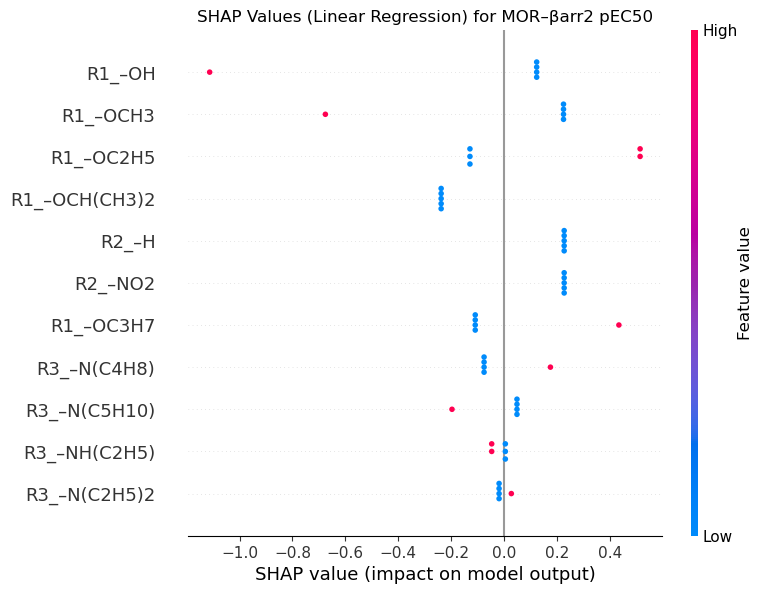

  0%|          | 0/5 [00:00<?, ?it/s]

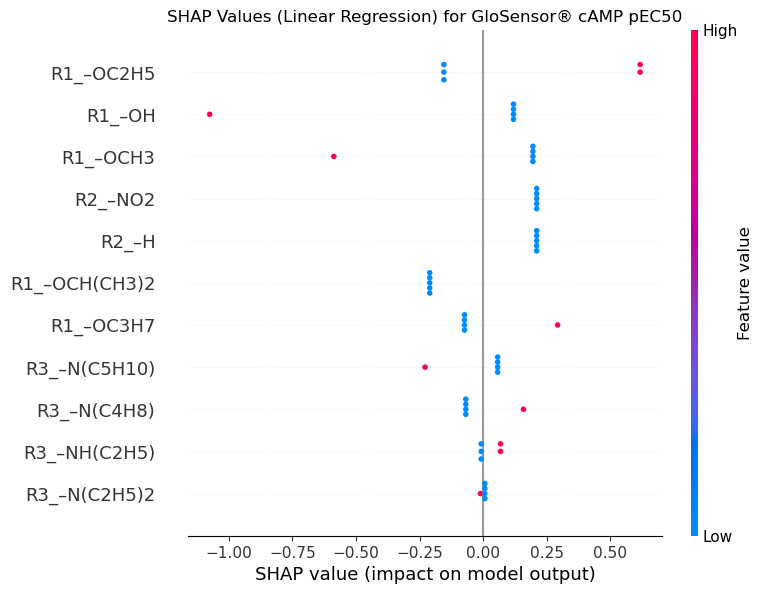

In [22]:
# SHAP analysis for all targets using Linear Regression
for i, target in enumerate(target_columns):
    # Linear Regression SHAP values
    explainer_lr = shap.KernelExplainer(lr_model.estimators_[i].predict, X_train)
    shap_values_lr = explainer_lr.shap_values(X_test)

    # Visualize SHAP summary for Linear Regression
    shap.summary_plot(shap_values_lr, X_test, feature_names=X.columns, show=False)
    plt.title(f'SHAP Values (Linear Regression) for {target}')
    filename = f"{output_dir}/shap_lr_{target.replace(' ', '_').replace('/', '_').replace('–', '-')}.png"
    plt.savefig(filename)
    plt.show()

# Partial Dependence

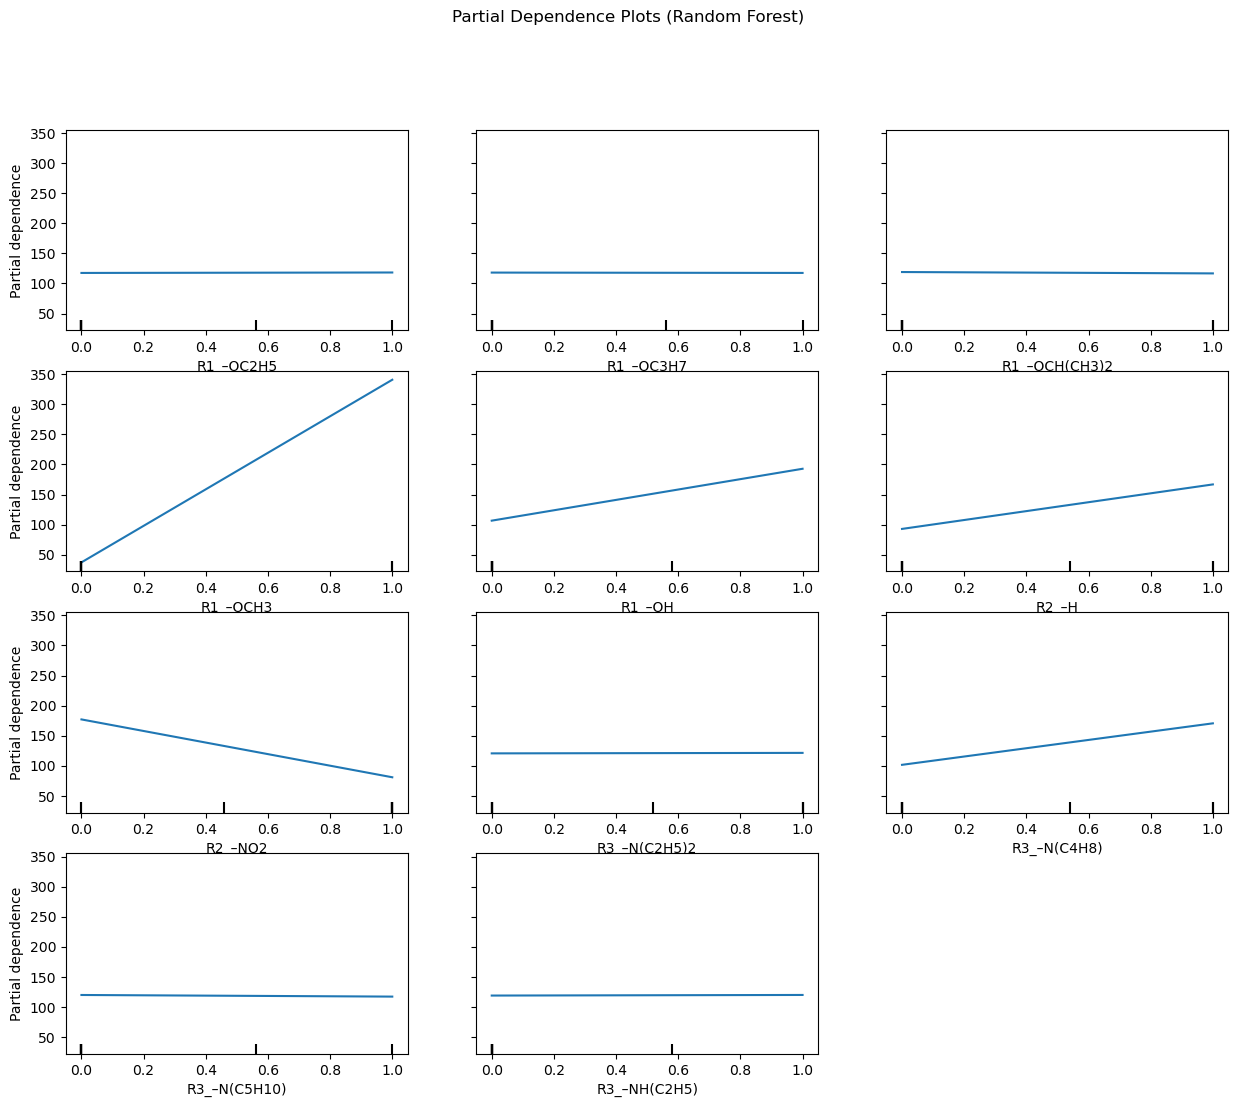

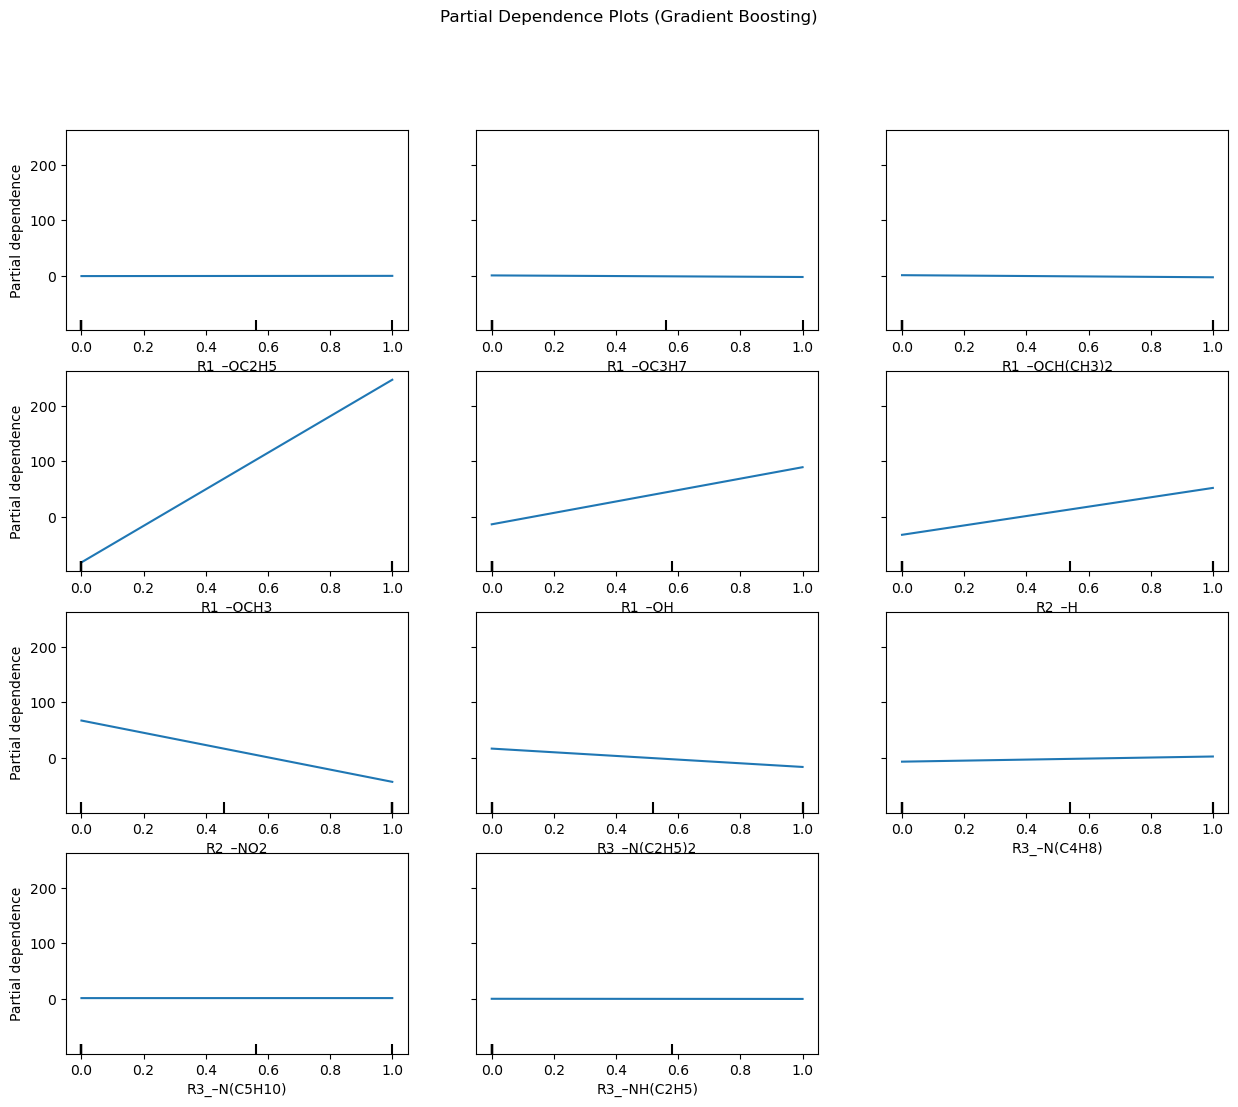

In [23]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Get all feature indices
all_features = list(range(X_train.shape[1]))  

# Combined analysis for Random Forest model (all features in one plot)
fig, ax = plt.subplots(figsize=(15, 12))
PartialDependenceDisplay.from_estimator(rf_model.estimators_[0], X_train, features=all_features, feature_names=X.columns, ax=ax)
plt.suptitle('Partial Dependence Plots (Random Forest)')
filename = f"{output_dir}/PDP_combined_rf.png"
plt.savefig(filename)
plt.show()

# Combined analysis for Gradient Boosting model (all features in one plot)
fig, ax = plt.subplots(figsize=(15, 12))
PartialDependenceDisplay.from_estimator(gb_model.estimators_[0], X_train, features=all_features, feature_names=X.columns, ax=ax)
plt.suptitle('Partial Dependence Plots (Gradient Boosting)')
filename = f"{output_dir}/PDP_combined_gb.png"
plt.savefig(filename)
plt.show()


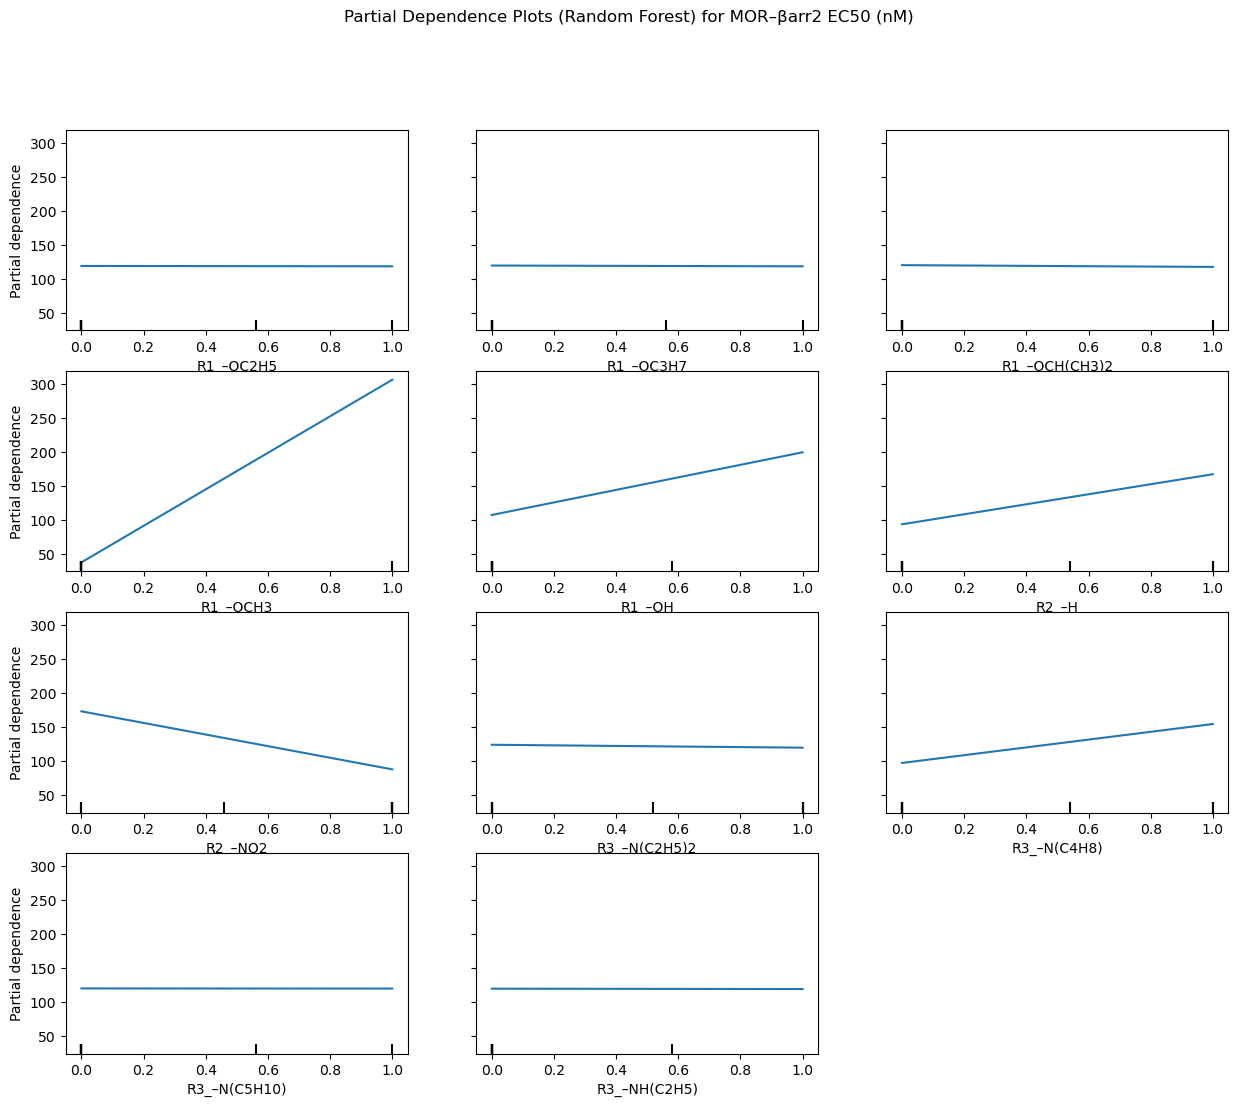

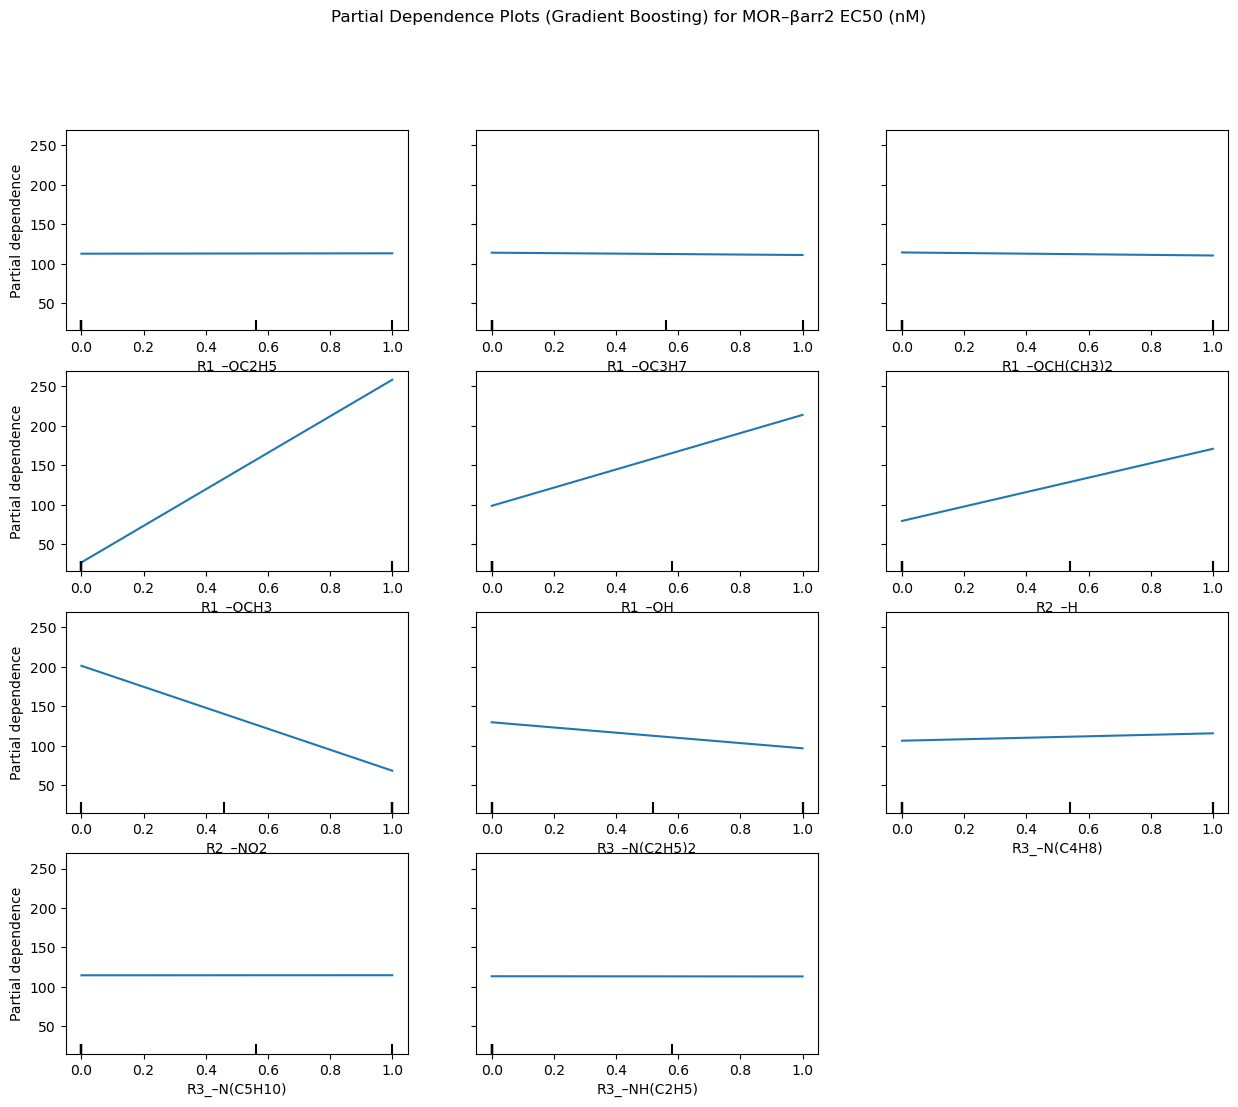

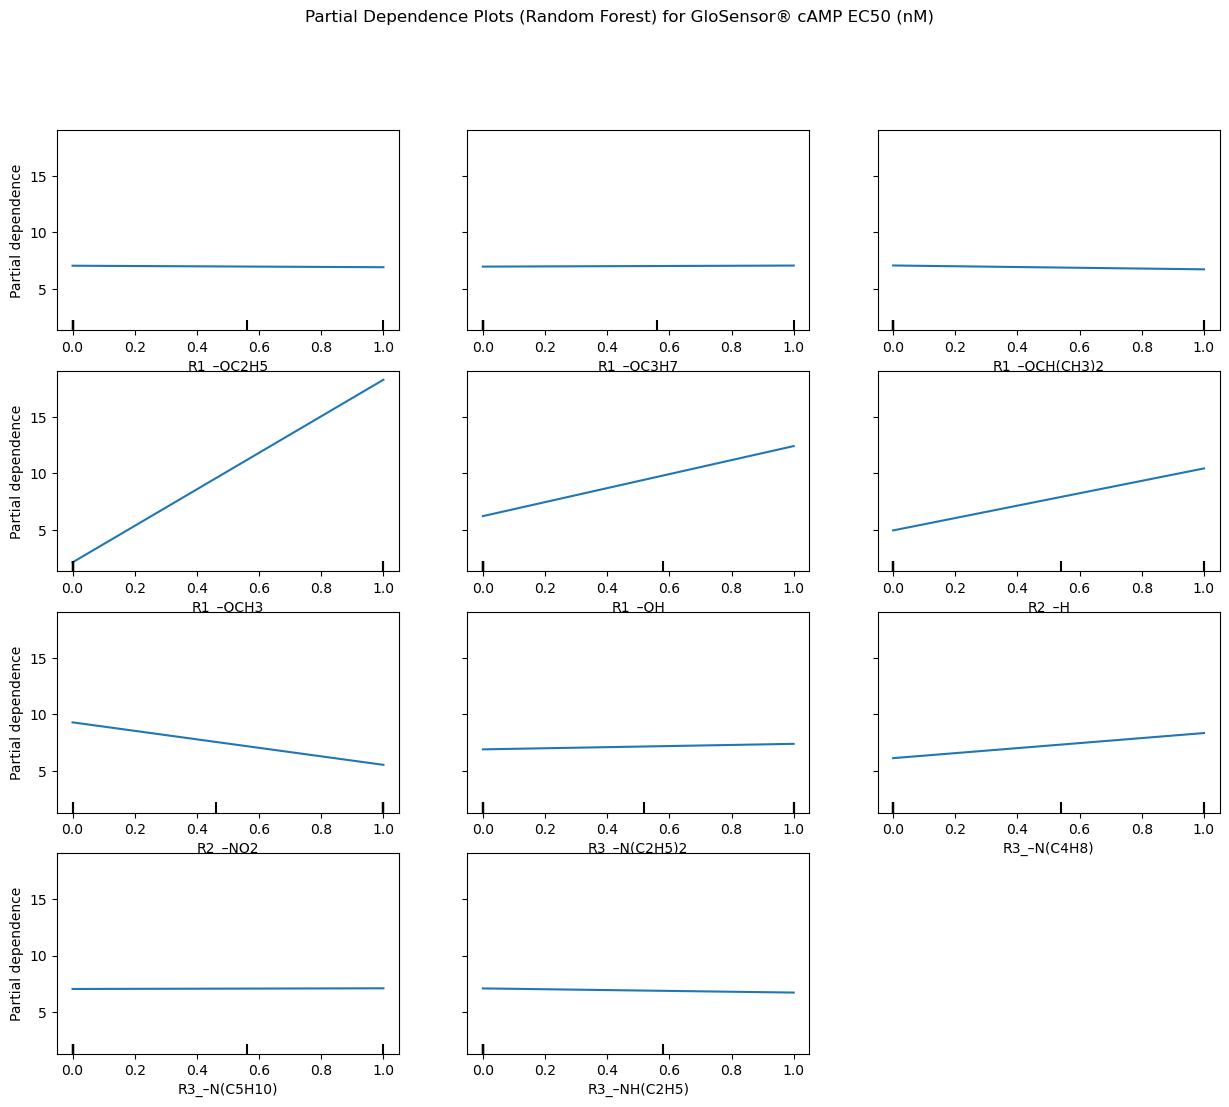

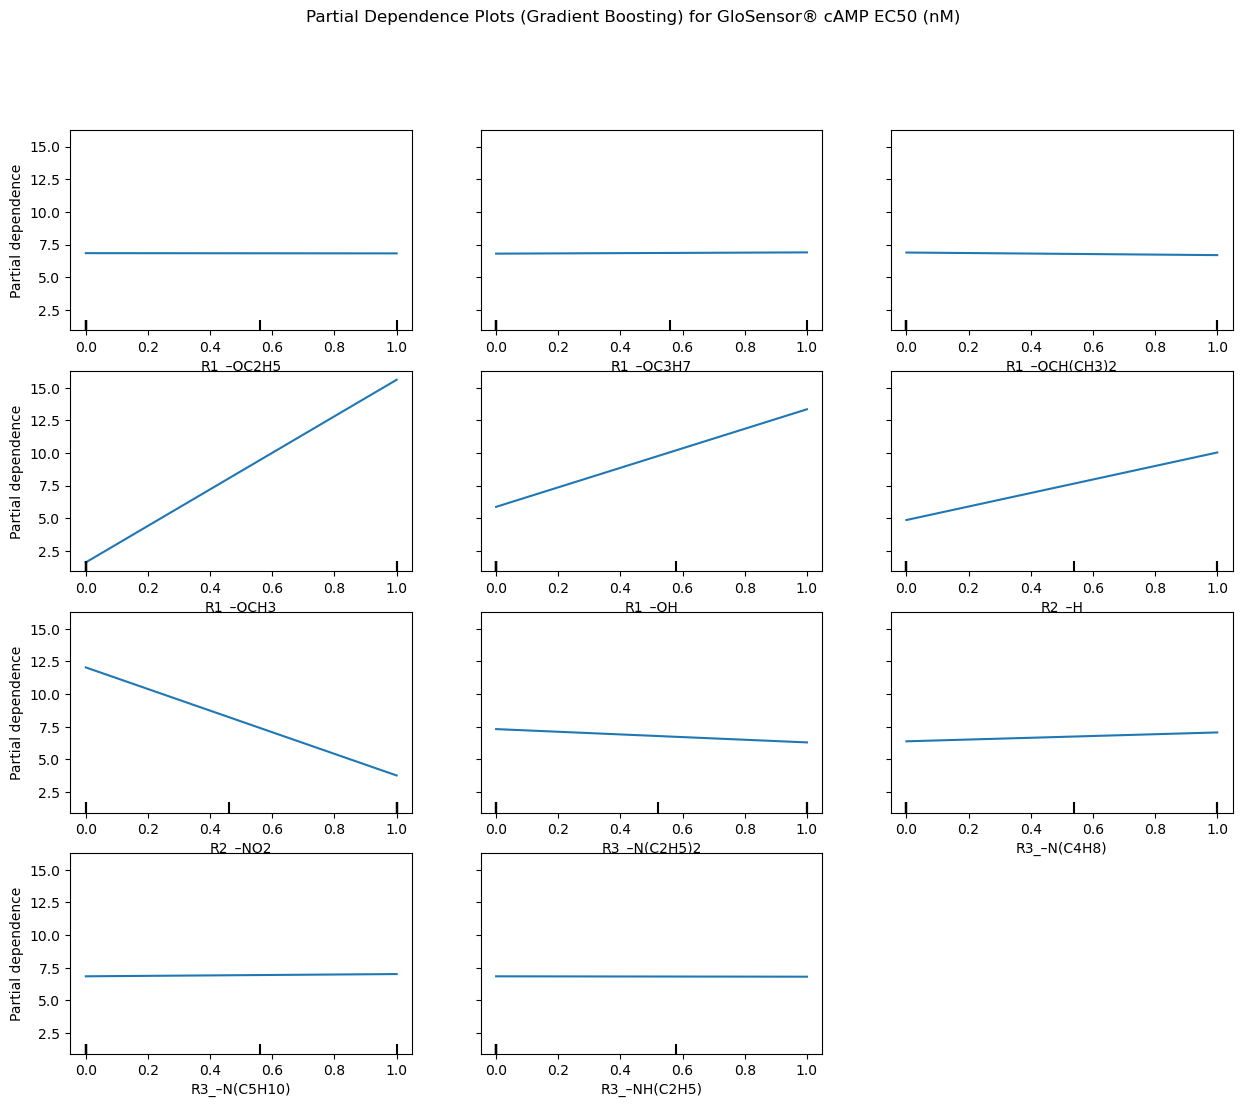

In [24]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Get all feature indices
all_features = list(range(X_train.shape[1]))

# Loop through each target for Random Forest and Gradient Boosting PDPs (all features in one plot)
for i, target in enumerate(target_columns):
    # Partial Dependence Plot for Random Forest
    fig, ax = plt.subplots(figsize=(15, 12))
    PartialDependenceDisplay.from_estimator(
        rf_model, X_train, features=all_features, feature_names=X.columns, target=i, ax=ax
    )
    plt.suptitle(f'Partial Dependence Plots (Random Forest) for {target}')
    filename = f"{output_dir}/PDP_rf_{target.replace(' ', '_').replace('/', '_').replace('–', '-')}.png"
    plt.savefig(filename)
    plt.show()

    # Partial Dependence Plot for Gradient Boosting
    fig, ax = plt.subplots(figsize=(15, 12))
    PartialDependenceDisplay.from_estimator(
        gb_model, X_train, features=all_features, feature_names=X.columns, target=i, ax=ax
    )
    plt.suptitle(f'Partial Dependence Plots (Gradient Boosting) for {target}')
    filename = f"{output_dir}/PDP_gb_{target.replace(' ', '_').replace('/', '_').replace('–', '-')}.png"
    plt.savefig(filename)
    plt.show()

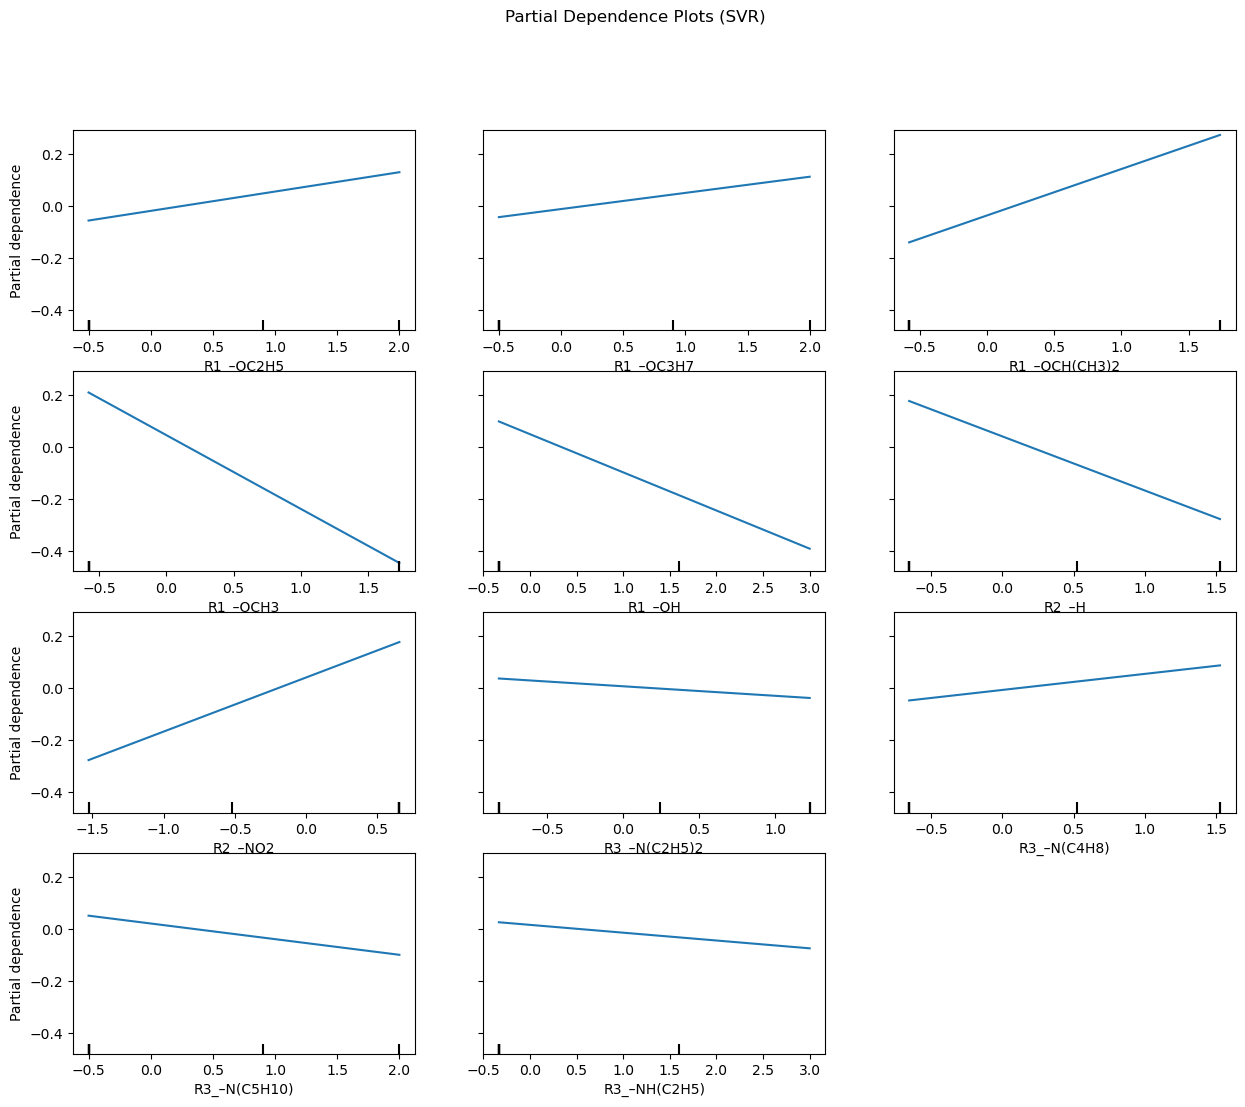

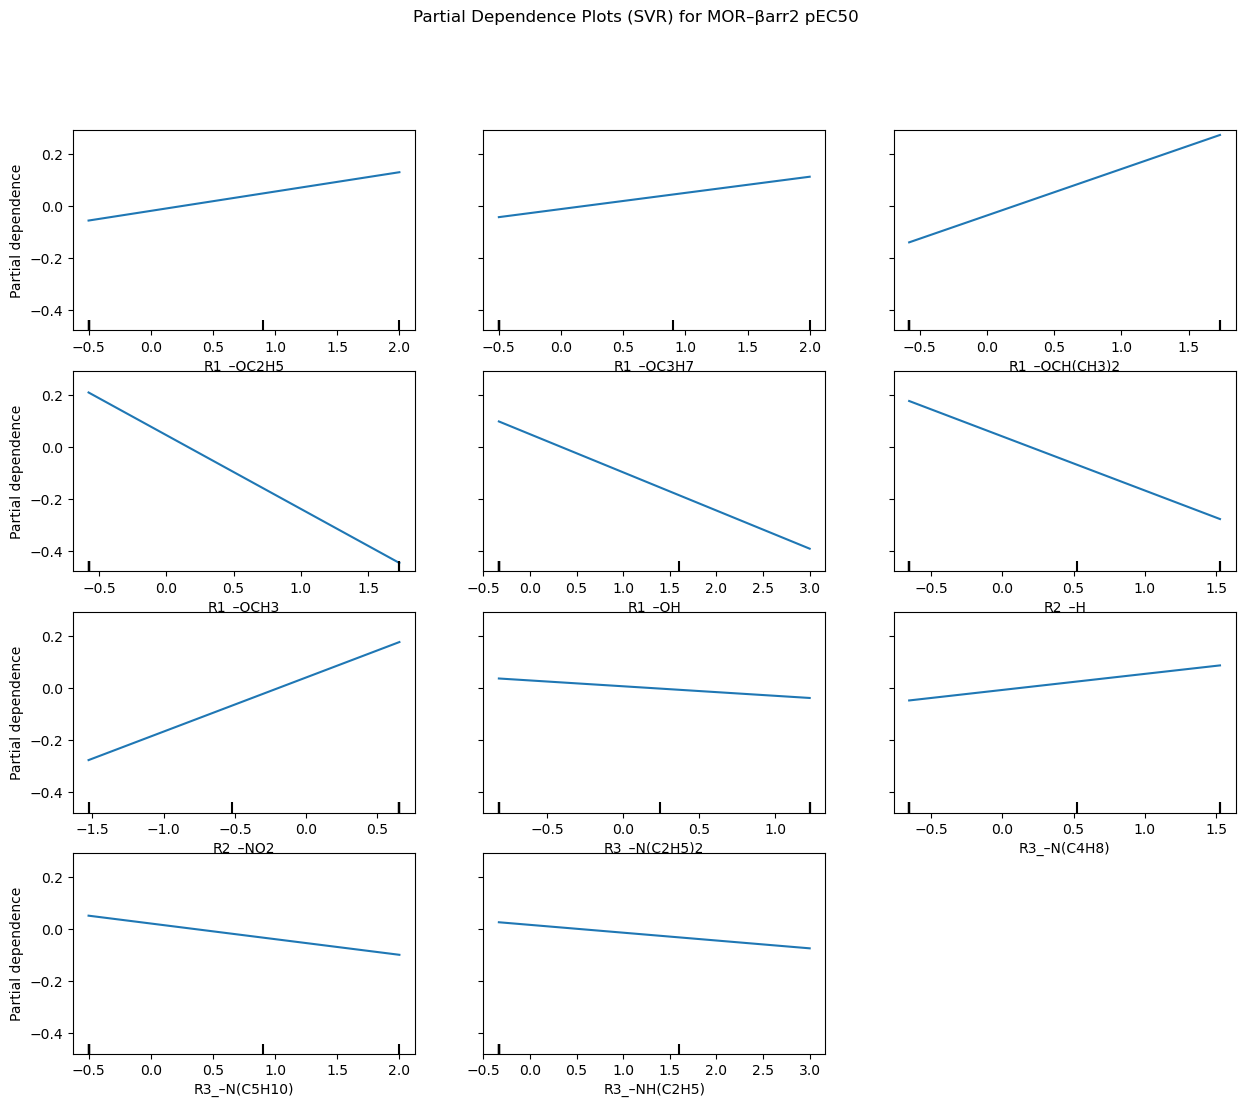

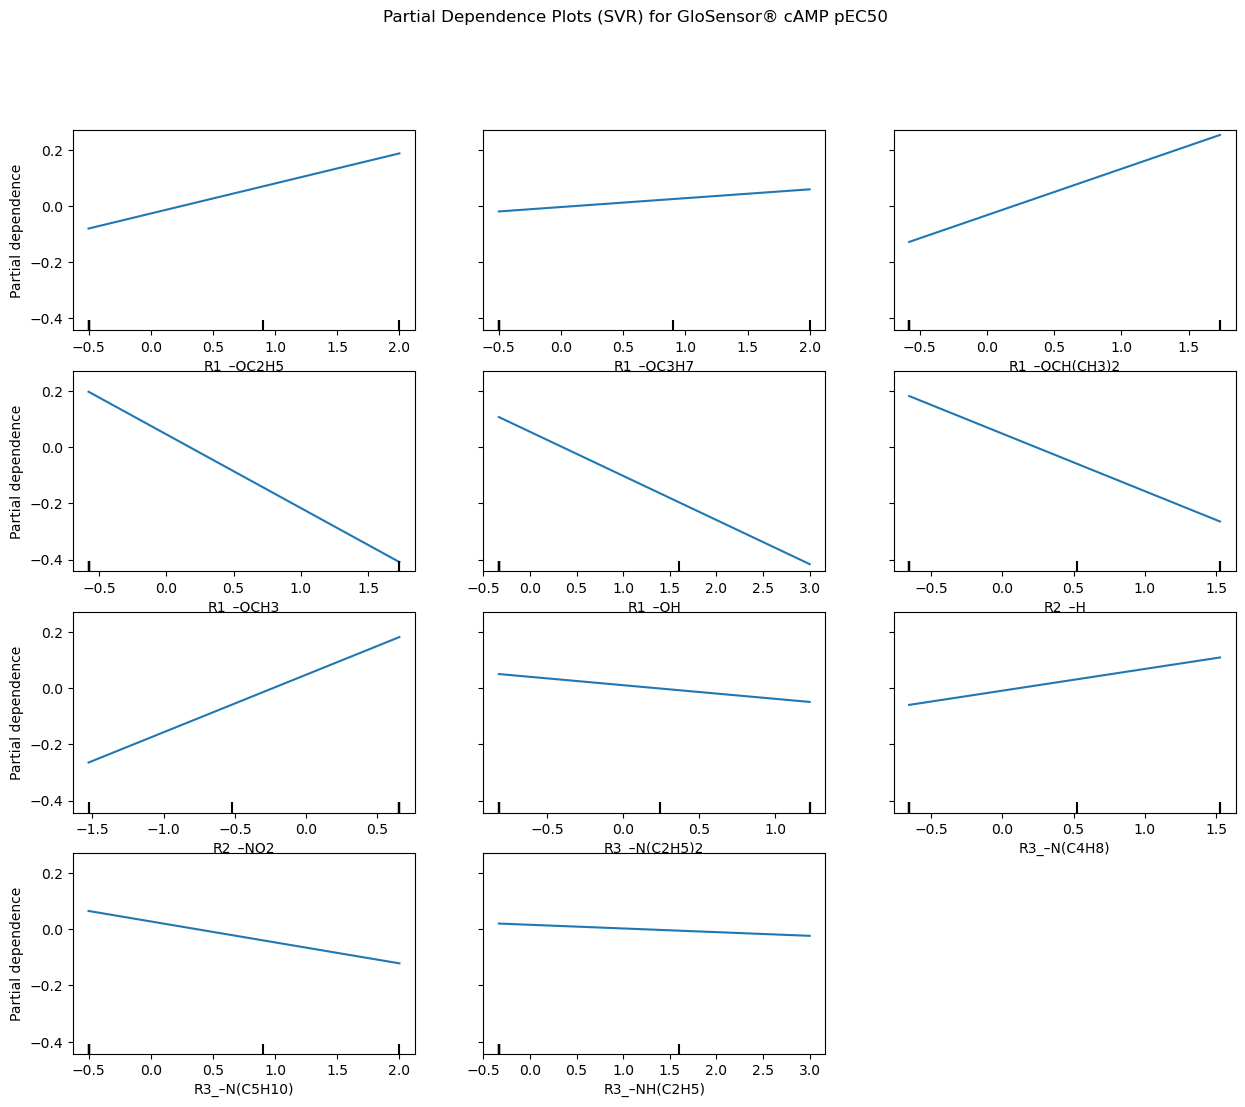

In [25]:
# PDP for SVR
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Get all feature indices
all_features = list(range(X_train.shape[1]))

# Combined
fig, ax = plt.subplots(figsize=(15, 12))
PartialDependenceDisplay.from_estimator(svr_model.estimators_[0], X_train_scaled, features=all_features, feature_names=X.columns, ax=ax)
plt.suptitle('Partial Dependence Plots (SVR)')
filename = f"{output_dir}/PDP_combined_svr.png"
plt.savefig(filename)
plt.show()

# Loop through each target for SVR PDPs (all features in one plot)
for i, target in enumerate(target_columns):
    # Partial Dependence Plot for SVR
    fig, ax = plt.subplots(figsize=(15, 12))
    PartialDependenceDisplay.from_estimator(
        svr_model, X_train_scaled, features=all_features, feature_names=X.columns, target=i, ax=ax
    )
    plt.suptitle(f'Partial Dependence Plots (SVR) for {target}')
    filename = f"{output_dir}/PDP_svr_{target.replace(' ', '_').replace('/', '_').replace('–', '-')}.png"
    plt.savefig(filename)
    plt.show()


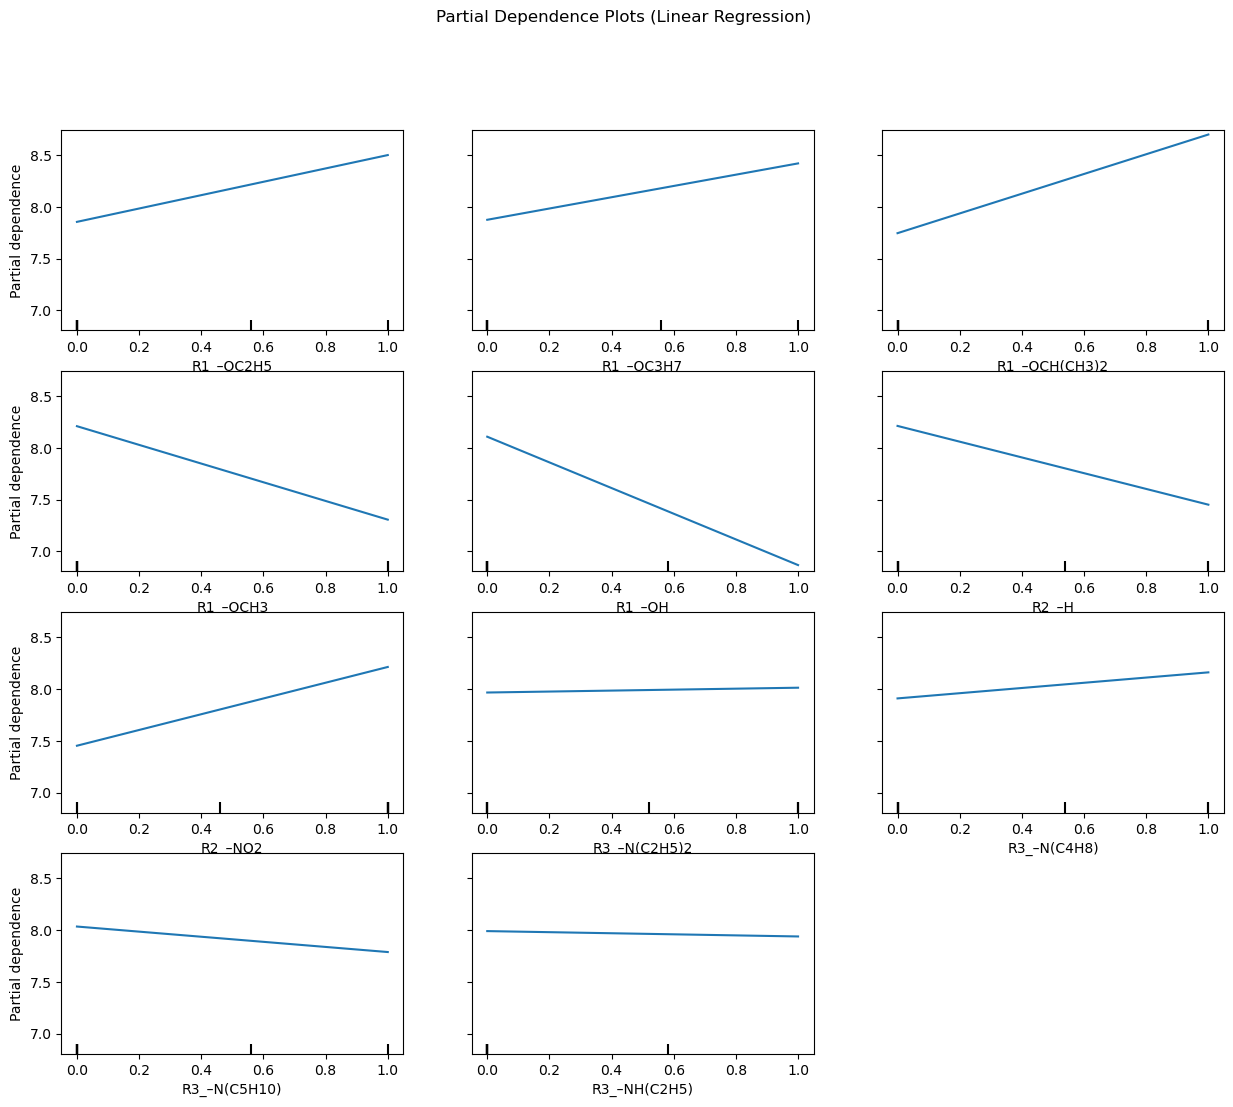

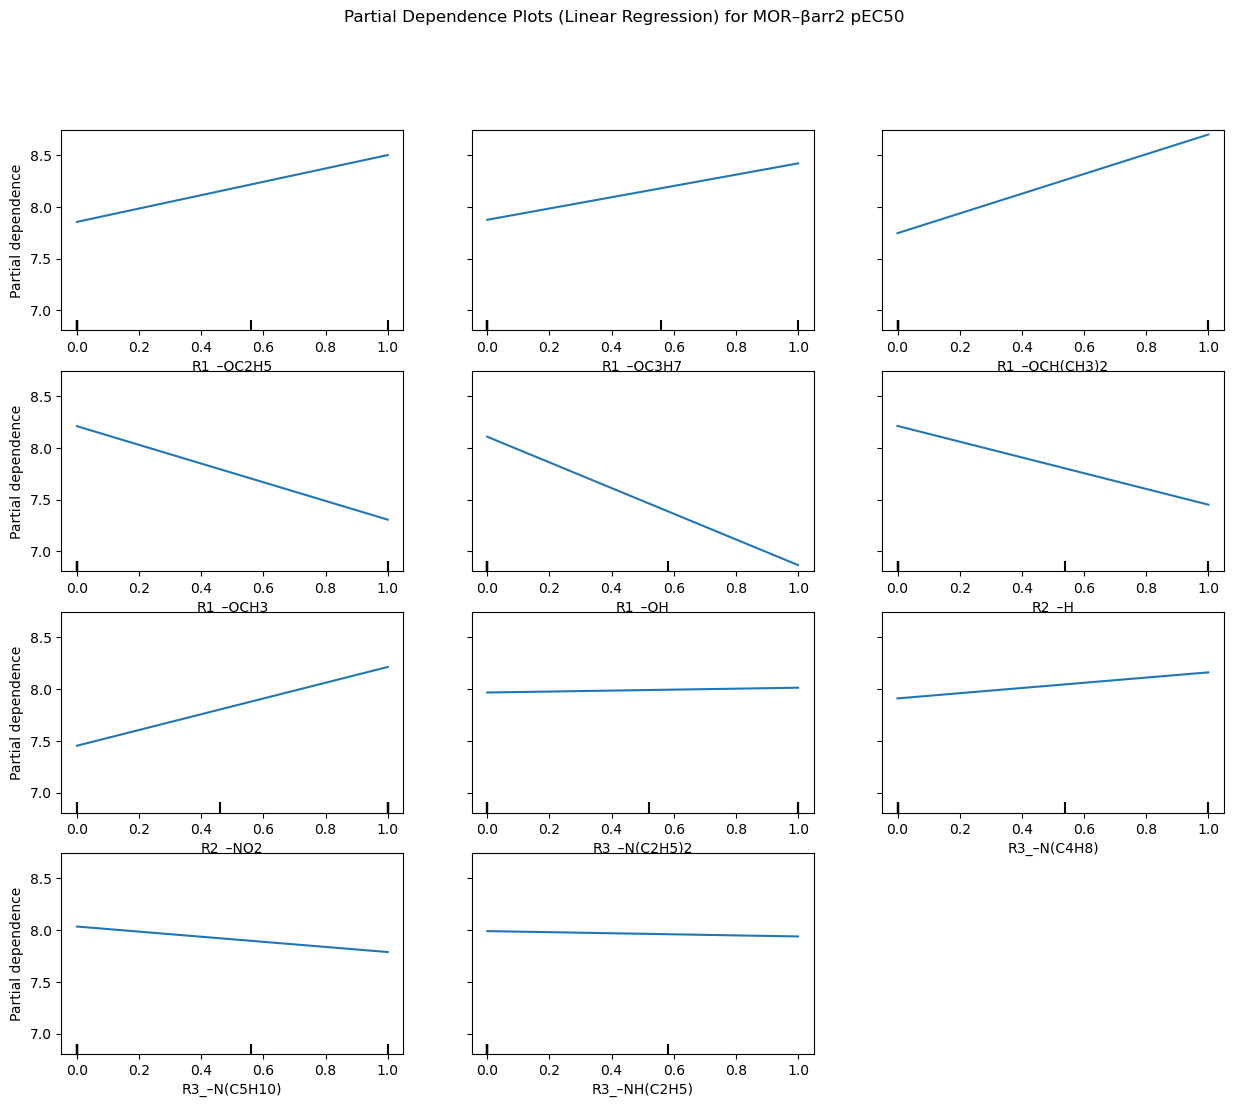

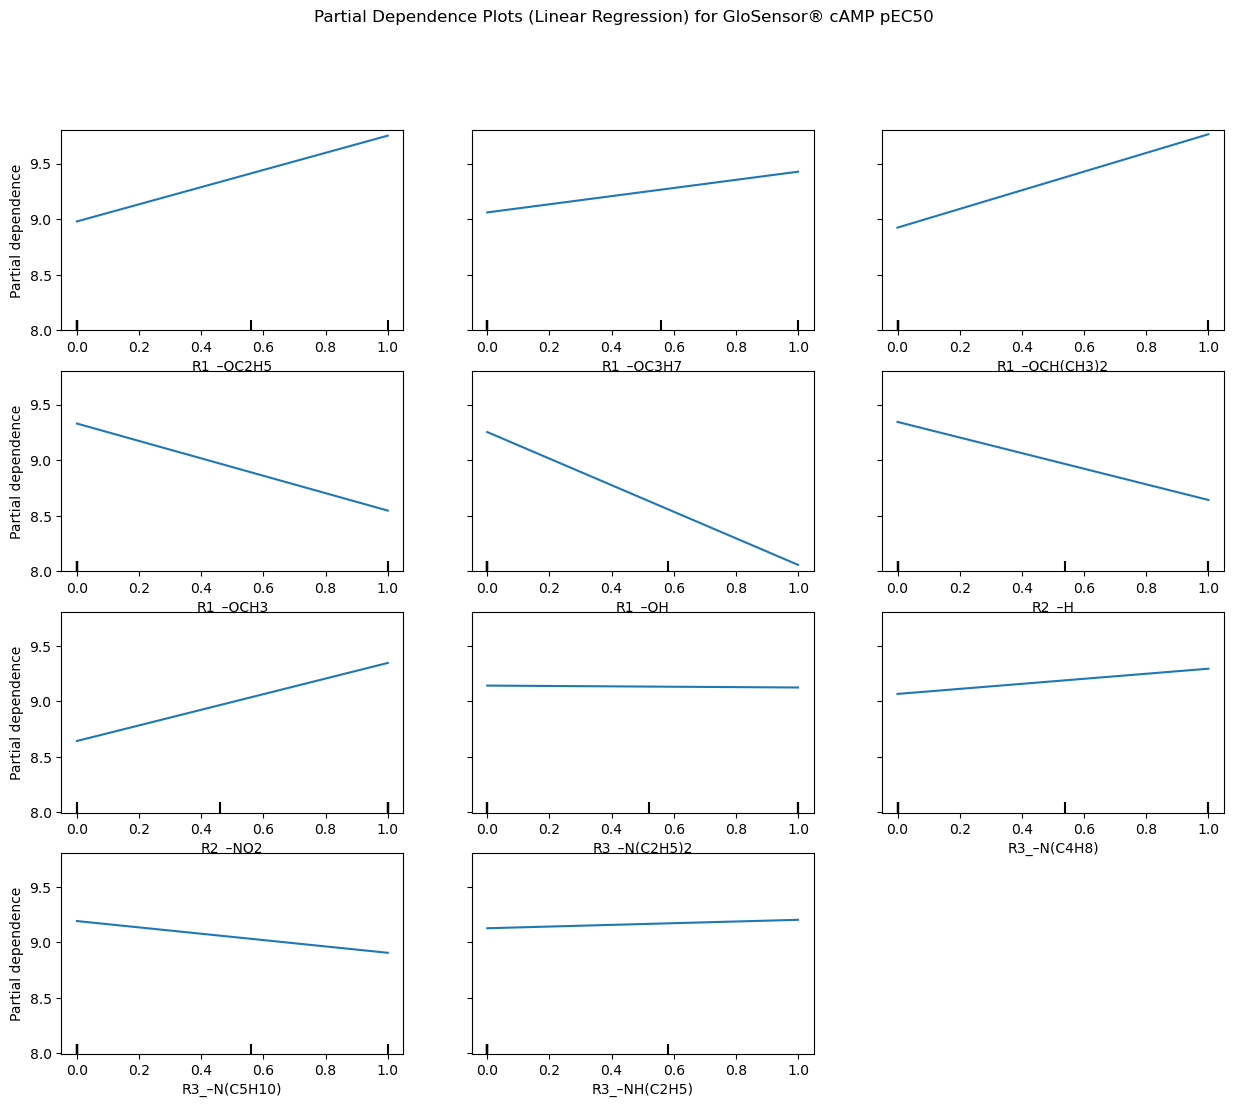

In [26]:
# PDP for Linear Regression
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Get all feature indices
all_features = list(range(X_train.shape[1]))

# Combined
fig, ax = plt.subplots(figsize=(15, 12))
PartialDependenceDisplay.from_estimator(lr_model.estimators_[0], X_train, features=all_features, feature_names=X.columns, ax=ax)
plt.suptitle('Partial Dependence Plots (Linear Regression)')
filename = f"{output_dir}/PDP_combined_lr.png"
plt.savefig(filename)
plt.show()

# Loop through each target for Linear Regression PDPs (all features in one plot)
for i, target in enumerate(target_columns):
    # Partial Dependence Plot for Linear Regression
    fig, ax = plt.subplots(figsize=(15, 12))
    PartialDependenceDisplay.from_estimator(
        lr_model, X_train, features=all_features, feature_names=X.columns, target=i, ax=ax
    )
    plt.suptitle(f'Partial Dependence Plots (Linear Regression) for {target}')
    filename = f"{output_dir}/PDP_lr_{target.replace(' ', '_').replace('/', '_').replace('–', '-')}.png"
    plt.savefig(filename)
    plt.show()